In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-tn-1463/TN_Mask_1463/TN_Mask_1463/20191026T195815_409_mask.png
/kaggle/input/test-tn-1463/TN_images_1463/__results___files/__results___11_0.png
/kaggle/input/test-tn-1463/TN_images_1463/TN_images_1463/20191115T105730_719.png
/kaggle/input/transfuse_segmentation_model/pytorch/default/1/TransFuse_best_model_epoch_196.pth
/kaggle/input/unet_segmentation_model/pytorch/default/1/unet_best_model_epoch_140.pth
/kaggle/input/medical-transformer_segmentation_model/pytorch/default/1/MedT_till_epoch_107_best_model_at_87.pth
/kaggle/input/raunet_segmentation_model/pytorch/default/1/RAUnet_best_model_epoch_80.pth
/kaggle/input/attention-unet_segmentation_model/pytorch/default/1/Attention-Unet_best_model_epoch_199.pth
/kaggle/input/transunet_segmentation_model/pytorch/default/1/TransUnet_best_model_epoch_100.pth


In [2]:
import warnings
warnings.filterwarnings("ignore")

Data load

In [3]:
def pad_image_to_square(img):
    if img.dim() == 3:  # For tensors with channels: [C, H, W]
        channels, height, width = img.shape
    elif img.dim() == 2:  # For tensors without channels: [H, W]
        height, width = img.shape
        channels = None
    else:
        raise ValueError("Input tensor must be 2D or 3D")

    # Calculate padding
    if height > width:
        pad_size = (height - width) // 2
        padding = (pad_size, height - width - pad_size, 0, 0)  # Left, right, top, bottom
    elif width > height:
        pad_size = (width - height) // 2
        padding = (0, 0, pad_size, width - height - pad_size)  # Left, right, top, bottom
    else:
        return img  # Already square, no padding needed

    # Apply padding
    padded_img = torch.nn.functional.pad(img.unsqueeze(0), padding, mode="constant", value=0).squeeze(0)
    if channels:
        return padded_img
    else:
        return padded_img.squeeze(0)  # Remove channel dimension if it was 2D

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
import os
import pandas as pd
from torchvision.io import read_image
import torch.utils.data as data

class CustomDataset(Dataset):
    def __init__(self, img_path, target_path, transform, target_transform):
        self.img_path = img_path 
        self.target_path = target_path
        self.transform = transform
        self.target_transform = target_transform

        # Define the mapping of pixel values to class labels
        self.class_mapping = {0: 0, 76: 1, 127: 1, 149: 2, 255: 2}  # Adjust based on your dataset

    def __len__(self):
        return len(os.listdir(self.img_path))

    def __getitem__(self, index):
        # Load and process the image
        img_path = os.path.join(self.img_path, sorted(os.listdir(self.img_path))[index])
        img = read_image(img_path)
        img_name = os.path.basename(img_path)
        img = pad_image_to_square(img)
        img = img.float() / 255.0
        

        # Load and process the target mask
        if self.target_path:
            mask_path = os.path.join(self.target_path, sorted(os.listdir(self.target_path))[index])
            mask_name = os.path.basename(mask_path)
            target = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            target = torch.from_numpy(target).long()  # Convert to long tensor
            target = pad_image_to_square(target)

            # Apply mapping to convert pixel values to class labels
            for key, value in self.class_mapping.items():
                target[target == key] = value

            # print(f"Remapped unique values in mask: {torch.unique(target)}")  # Debugging remapped values

            if self.target_transform and len(target.size()) > 1:
                target = self.target_transform(target.unsqueeze(0)).squeeze(0)
        else:
            target = torch.tensor([])

        # Apply transformations to the image
        if self.transform:
            img = self.transform(img)

        return img.float(), target,  img_name, mask_name

# Define the transformation to resize the images to a fixed size
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Use nearest interpolation to preserve class labels in the target masks
transform1 = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.NEAREST),
])

# Instantiate dataset objects
# dataset = CustomDataset(
#     img_path='/kaggle/input/unetdata/denoised_Standard_plane/Standard_plane',
#     target_path='/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks',
#     transform=transform,
#     target_transform=transform1
# )

test_dataset = CustomDataset(
    img_path='/kaggle/input/test-tn-1463/TN_images_1463/TN_images_1463',
    target_path='/kaggle/input/test-tn-1463/TN_Mask_1463/TN_Mask_1463',
    transform=transform,
    target_transform=transform1
)

# # Check the number of images
# img_path = '/kaggle/input/unetdata/denoised_Standard_plane/Standard_plane'
# print(len(os.listdir(img_path)))

# target_path = '/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks'
# print(len(os.listdir(target_path)))

test_img_path = '/kaggle/input/test-tn-1463/TN_images_1463/TN_images_1463'
print(len(os.listdir(test_img_path)))

test_target_path = '/kaggle/input/test-tn-1463/TN_Mask_1463/TN_Mask_1463'
print(len(os.listdir(test_target_path)))

# Split the dataset into training and validation sets
# train_dataset, val_dataset = data.random_split(dataset, [6067, 1517], generator=torch.Generator().manual_seed(42))

# Create train and validation dataloaders
# train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

1463
1463


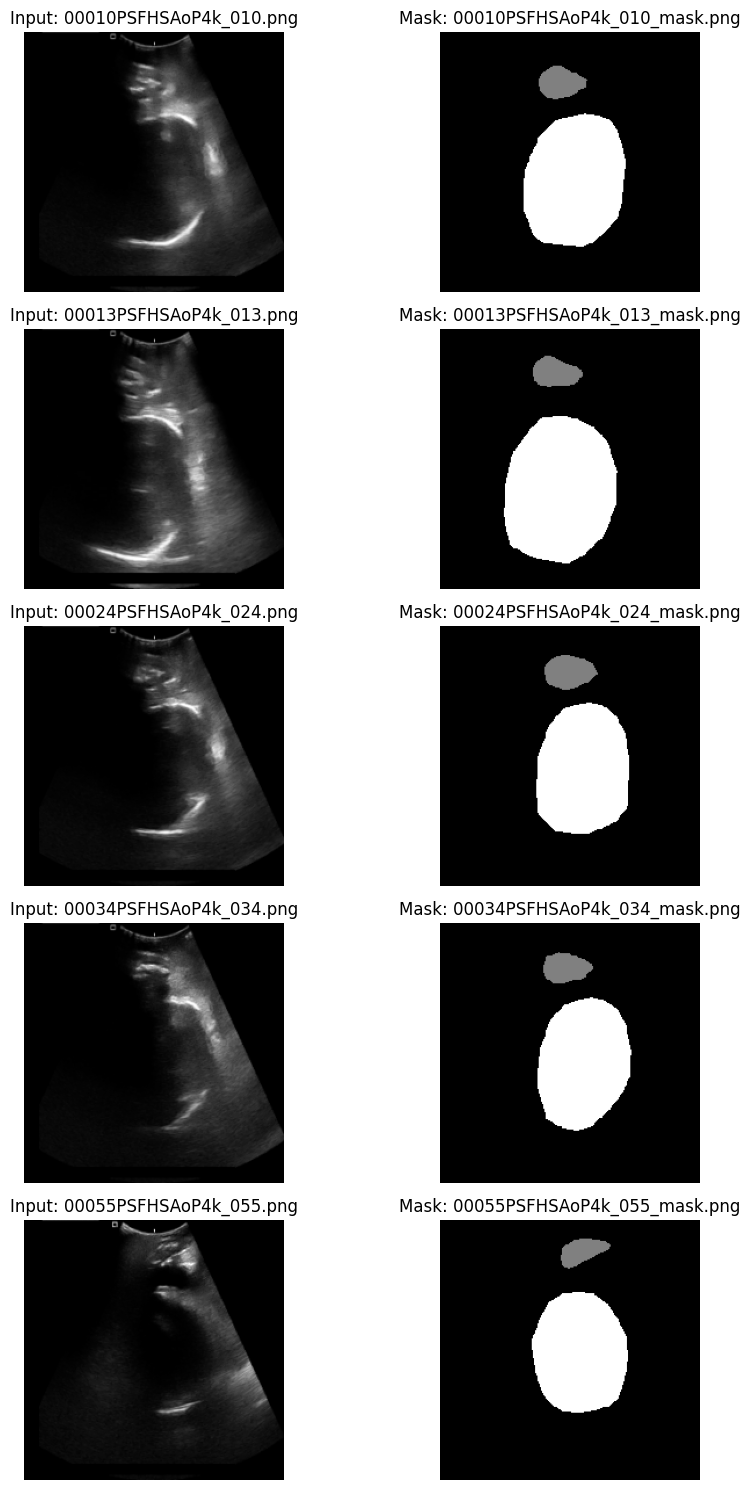

In [5]:
import matplotlib.pyplot as plt
import torch


# Get one batch of data
for i, batch in enumerate(test_dataloader):
    if i == 1:
        break  # Only take the first batch

    # Unpack batch
    images, masks, img_names, mask_names = batch  # images: (batch_size, C, H, W), masks: (batch_size, H, W)

    num_images = min(5, images.shape[0])  # Show up to 5 images

    # Create a figure with 5 rows and 2 columns
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(10, num_images * 3))

    for j in range(num_images):
        # Original Image (Column 1)
        axs[j, 0].imshow(images[j, 0].cpu().numpy(), cmap='gray')  # Convert to NumPy
        axs[j, 0].set_title(f"Input: {img_names[j]}")
        axs[j, 0].axis('off')

        # Corresponding Mask (Column 2)
        axs[j, 1].imshow(masks[j].cpu().numpy(), cmap='gray')  # Convert to NumPy
        axs[j, 1].set_title(f"Mask: {mask_names[j]}")
        axs[j, 1].axis('off')

    plt.tight_layout()
    plt.show()

Evaluation Metrics

In [6]:
# # def match_dims_with_pred_mask(groundtruth_mask):
# #   # print("Shape of groundtruth_mask before one-hot encoding:", groundtruth_mask.shape)

# #   num_classes = 3
# #   groundtruth_mask = np.eye(num_classes)[groundtruth_mask]  
# #   # print("Shape after one-hot encoding (temporary):", groundtruth_mask.shape)

# #   groundtruth_mask = np.moveaxis(groundtruth_mask, -1, 1)  
# #   # print("Shape after axis reordering:", groundtruth_mask.shape)
# #   return groundtruth_mask


# # Dice score: Measures the overlap between the predicted and ground truth masks. A value of 1 indicates perfect overlap.
# # The more the better
# def dice_coef_without_class(pred_mask,groundtruth_mask):
#     pred_mask = np.array(pred_mask)
#     # print("pred_mask shape: ",pred_mask.shape)
#     groundtruth_mask = np.array(groundtruth_mask)
#     # groundtruth_mask = match_dims_with_pred_mask(groundtruth_mask)
    
#     smooth = 0.0001
#     intersect = np.sum(pred_mask*groundtruth_mask) + smooth
#     total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask) + smooth
#     dice = np.mean(2*intersect/total_sum)
#     return round(dice, 5)

# def dice_coef(pred_masks, groundtruth_masks):
    
#     pred_masks = np.array(pred_masks)
#     # print("pred_masks shape: ",pred_masks.shape)
#     groundtruth_masks = np.array(groundtruth_masks)
#     # groundtruth_masks = match_dims_with_pred_mask(groundtruth_masks)

#     smooth = 1e-6  # Smoothing value to avoid division by zero
#     dice_per_class = []
#     num_classes = 3

#     for class_idx in range(num_classes):
#         # Create binary masks for the current class
#         pred_class = (pred_masks == class_idx).astype(np.float32)
#         groundtruth_class = (groundtruth_masks == class_idx).astype(np.float32)

#         # Calculate Dice for the current class
#         intersection = np.sum(pred_class * groundtruth_class, axis=(1, 2))  # Sum over spatial dimensions
#         total_sum = np.sum(pred_class, axis=(1, 2)) + np.sum(groundtruth_class, axis=(1, 2))
#         dice_class = (2. * intersection + smooth) / (total_sum + smooth)

#         # Average Dice across the batch for this class
#         dice_per_class.append(np.mean(dice_class))

#     # Macro-average Dice (mean across all classes)
#     mean_dice = np.mean(dice_per_class)
#     return round(mean_dice, 5)

#     # smooth = 0.001
#     # dice_per_class = torch.zeros(3)
#     # for class_id in range(3):
#     #     y_pred_class = (pred_masks == class_id).float()
#     #     y_true_class = (groundtruth_masks == class_id).float()

#     #     intersection = torch.sum(y_pred_class*y_true_class)
#     #     dice_per_class[class_id] = (2.0 * intersection + smooth) / (
#     #         torch.sum(y_pred_class) + torch.sum(y_true_class)+smooth
#     #     )

#     # return dice_per_class



# # Jaccard Index (IoU): Measures the intersection over the union of the predicted and ground truth masks.
# # The more the better
# def iou(pred_mask,groundtruth_mask):
#     pred_mask = np.array(pred_mask)
#     groundtruth_mask = np.array(groundtruth_mask)
#     # groundtruth_mask = match_dims_with_pred_mask(groundtruth_mask)
 
#     smooth = 0.0001
#     intersect = np.sum(pred_mask*groundtruth_mask)
#     union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
#     iou = (intersect + smooth) / (union + smooth)  # Calculate per image IoU
#     return round(np.mean(iou),5)  # Average IoU across all images in the batch


# # Average Surface Distance (ASD): Measures the average distance between the boundary points of the predicted mask and the ground truth mask.
# # The less the better


# # Volume Overlap Error (VOE): For non-binary masks, VOE can be adapted by considering the sum of pixel values as a "soft overlap"
# # Lower values are better.
# def voe(pred_mask, gt_mask):
#     pred_mask = np.array(pred_mask)
#     gt_mask = np.array(gt_mask)
#     # gt_mask = match_dims_with_pred_mask(gt_mask)

#     smooth = 0.000001
#     intersection = np.sum(np.minimum(pred_mask, gt_mask))  # Soft overlap
#     union = np.sum(np.maximum(pred_mask, gt_mask))        # Soft union
#     voe = 1 - ((intersection+smooth) / (union+smooth))
#     return round(voe,5)


# # Relative Volume Difference (RVD): RVD is particularly useful for applications where the total volume
# # (e.g., of an organ or lesion) is more important than boundary alignment. It captures whether 
# # the predicted segmentation overestimates or underestimates the actual volume.
# # The range of Relative Volume Difference (RVD) is unbounded and can theoretically span from −∞ to +∞, depending 
# # on the degree of overestimation or underestimation of the predicted volume compared to the ground truth volume. 

# # Negative RVD (RVD<0):Indicates that the predicted volume is smaller than the ground truth.
# # Example: RVD=−0.2 means the predicted volume is 20% smaller.

# # Zero RVD (RVD=0): Indicates a perfect match between the predicted and ground truth volumes.

# # Positive RVD (RVD>0): Indicates that the predicted volume is larger than the ground truth.
# # Example: RVD=0.15 means the predicted volume is 15% larger.

# # Lower values are better.

# def rvd(pred_mask, gt_mask):
#     pred_mask = np.array(pred_mask)
#     gt_mask = np.array(gt_mask)
#     # gt_mask = match_dims_with_pred_mask(gt_mask)

#     smooth = 0.0001
#     pred_volume = np.sum(pred_mask)  # Sum of intensities
#     gt_volume = np.sum(gt_mask)     # Sum of intensities
#     rvd = (pred_volume - gt_volume) / (gt_volume)
#     return round(rvd,5)

Maybe Final one's

In [7]:
def relative_volume_difference(y_pred, y_true):
    rvd_list = []
    n_classes = 3
    smooth = 0.0001
    for class_id in range(n_classes):
        
        y_pred_class = (y_pred == class_id).float()
        y_true_class = (y_true == class_id).float()
        
        # Calculate the volumes (i.e., the sum of non-zero pixels)
        V_pred = torch.sum(y_pred_class)
        V_gt = torch.sum(y_true_class)
        
        # Calculate RVD for this class
        if V_gt != 0:
            rvd = torch.abs(V_pred - V_gt) / V_gt
        else:
            print("rvd")
            rvd = 0  # If the ground truth volume is zero, set RVD to zero (or some other default)
        
        rvd_list.append(rvd)
    
    # Return the mean RVD across all classes
    return torch.mean(torch.tensor(rvd_list))

# Volume Overlap Error (VOE) for multiclass segmentation
def volume_overlap_error(y_pred, y_true):
    voe_list = []
    n_classes = 3
    smooth = 0.000001
    for class_id in range(n_classes):
        
        y_pred_class = (y_pred == class_id).float()
        y_true_class = (y_true == class_id).float()
        
        # Calculate the intersection and union
        intersection = torch.sum(y_pred_class * y_true_class)
        union = torch.sum(torch.max(y_pred_class, y_true_class))
        
        # Calculate VOE for this class
        voe = (union - intersection) / (union + smooth)
        
        voe_list.append(voe)
    
    # Return the mean VOE across all classes
    return torch.mean(torch.tensor(voe_list))



Unet

In [8]:
# import torch
# import torch.nn as nn
# import torchvision.transforms.functional as TF

# class DoubleConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(DoubleConv, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 3, 1, 1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, 3, 1, 1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#         )

#     def forward(self, x):
#         return self.conv(x)

# class UNET(nn.Module):
#     def __init__(
#             self, in_channels=1, out_channels=3, features=[64, 128, 256, 512],
#     ):
#         super(UNET, self).__init__()
#         self.downs = nn.ModuleList()
#         self.ups = nn.ModuleList()
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

#         # Down part of UNET
#         for feature in features:
#             self.downs.append(DoubleConv(in_channels, feature))
#             in_channels = feature

#         # Up part of UNET
#         for feature in reversed(features):
#             self.ups.append(
#                 nn.ConvTranspose2d(
#                     feature*2, feature, kernel_size=2, stride=2,
#                 )
#             )
#             self.ups.append(DoubleConv(feature*2, feature))

#         self.bottleneck = DoubleConv(features[-1], features[-1]*2)
#         self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

#     def forward(self, x):
#         skip_connections = []

#         for down in self.downs:
#             x = down(x)
#             skip_connections.append(x)
#             x = self.pool(x)

#         x = self.bottleneck(x)
#         skip_connections = skip_connections[::-1]

#         for idx in range(0, len(self.ups), 2):
#             x = self.ups[idx](x)
#             skip_connection = skip_connections[idx//2]

#             if x.shape != skip_connection.shape:
#                 x = TF.resize(x, size=skip_connection.shape[2:])

#             concat_skip = torch.cat((skip_connection, x), dim=1)
#             x = self.ups[idx+1](concat_skip)

#         return self.final_conv(x)




# from torchsummary import summary

# model = UNET(in_channels=1, out_channels=3)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
    
# model.to(device)
# print(model)
    
# print(summary(model, input_size=(1, 224,224)))

In [9]:
# import os
# import numpy as np
# from PIL import Image

# # From the best net

# model_weight_path = '/kaggle/input/unet_segmentation_model/pytorch/default/1/unet_best_model_epoch_140.pth'

# net = model.to(device)

# net.load_state_dict(torch.load(model_weight_path))
# print(net.load_state_dict(torch.load(model_weight_path)))

# net.eval()


# # Create an output directory for predicted masks
# output_dir_work = "/kaggle/working/Unet/predicted_masks"
# os.makedirs(output_dir_work, exist_ok=True)

# output_dir = "/kaggle/outputs/Unet/predicted_images/"
# os.makedirs(output_dir, exist_ok=True)

# # Mapping dictionary
# value_mapping = {0: 0, 1: 127, 2: 255}

# with torch.no_grad():
#     test_loss = []
#     test_msk = []
#     test_pred_msk = []
#     test_img = []
#     all_image_names = []
#     all_mask_names = []
      
#     for batch in test_dataloader:
#         test_images, test_masks, img_names, mask_names = batch
        
#         test_images = test_images.to(device)
#         test_masks = test_masks.to(device)

#         predicted_masks = net(test_images)
#         predicted_masks = torch.argmax(predicted_masks, dim=1)

#         # predicted_masks = net(test_images)
#         # predicted_masks = torch.argmax(predicted_masks, dim=1).cpu().numpy().astype(np.uint8)

#         test_img.extend(test_images.cpu().numpy())
#         test_msk.extend(test_masks.cpu().numpy())
#         test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

#         all_image_names.extend(img_names)
#         all_mask_names.extend(mask_names)

#         # Save predicted masks as PNG images while keeping the original segmentation values (0,1,2)
#         for i in range(predicted_masks.shape[0]):
#             pred_mask = predicted_masks[i].cpu().numpy()  # Keep class values unchanged (0,1,2)
#             # Apply the mapping: 0 → 0, 1 → 127, 2 → 255
#             pred_mask = np.vectorize(value_mapping.get)(pred_mask).astype(np.uint8)
#             # print(mask_names[i])
#             pred_mask_img = Image.fromarray(pred_mask)  # No scaling, original values retained
#             pred_mask_path = os.path.join(output_dir_work, f"pred_{mask_names[i]}")
#             pred_mask_img.save(pred_mask_path)
#             pred_mask_path = os.path.join(output_dir, f"pred_{mask_names[i]}")
#             pred_mask_img.save(pred_mask_path)

# print(f"Saved predicted masks in: {output_dir}")


    
#     # batch = next(iter(test_dataloader))
#     # test_images, test_masks, img_names, mask_names = batch
        
#     # test_images = test_images.to(device)
#     # test_masks = test_masks.to(device)

#     # predicted_masks = net(test_images)
#     # predicted_masks = torch.argmax(predicted_masks, dim=1)

#     # test_img.extend(test_images.cpu().numpy())
#     # test_msk.extend(test_masks.cpu().numpy())
#     # test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

#     # all_image_names.extend(img_names)
#     # all_mask_names.extend(mask_names)
  
    
# # test_dice = dice_coef(test_pred_msk,test_msk)
# # test_dice_wo = dice_coef_without_class(test_pred_msk,test_msk)
# # test_iou = iou(test_pred_msk,test_msk)
# # test_voe = voe(test_pred_msk,test_msk)
# # test_rvd = rvd(test_pred_msk,test_msk)
      
# # # Print the loss for the current epoch
# # print(len(all_mask_names))
# # print(f"test dice: {test_dice:.4f}, test dice wo: {test_dice_wo}, test jaccard: {test_iou}, test voe: {test_voe}, test rvd: {test_rvd}")

In [10]:
# import torch
# from torchmetrics import JaccardIndex, Dice

# n_classes = 3

# # IoU (Jaccard Index) metric
# iou_metric = JaccardIndex(task="multiclass", num_classes=n_classes)

# # Dice Score metric (also called F1 Score for segmentation)
# dice_metric = Dice(num_classes=n_classes, average='macro')

# # Convert ground truth and prediction to PyTorch tensors
# y_test_tensor = torch.tensor(test_msk, dtype=torch.int64)   # (16, 224, 224)
# y_pred_tensor = torch.tensor(test_pred_msk, dtype=torch.int64)   # (16, 224, 224)

# # Ensure tensors are on the same device (important for GPUs)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# y_test_tensor = y_test_tensor.to(device)
# y_pred_tensor = y_pred_tensor.to(device)

# iou_metric = iou_metric.to(device)
# dice_metric = dice_metric.to(device)

# # Compute IoU
# mean_iou = iou_metric(y_pred_tensor, y_test_tensor)
# print("Mean IoU =", mean_iou.item())

# # Compute Dice Score
# dice_score = dice_metric(y_pred_tensor, y_test_tensor)
# print("Dice Score =", dice_score.item())

# rvd = relative_volume_difference(y_pred_tensor, y_test_tensor)
# print("Relative Volume Difference (RVD) =", rvd.item())

# voe = volume_overlap_error(y_pred_tensor, y_test_tensor)
# print("Volume Overlap Error (VOE) =", voe.item())

Attention Unet

In [11]:
# import torch
# import torch.nn as nn
# import torchvision.transforms.functional as TF
# import torch.nn.functional as F
# from torch.nn.parameter import Parameter

# # ------------------------- ECA Implementation -------------------------

# class eca_layer(nn.Module):
#     """Constructs a ECA module.

#     Args:
#         channel: Number of channels of the input feature map
#         k_size: Adaptive selection of kernel size
#     """
#     def __init__(self, channel, k_size=3):
#         super(eca_layer, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False) 
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         # feature descriptor on the global spatial information
#         y = self.avg_pool(x)

#         # Two different branches of ECA module
#         y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)

#         # Multi-scale information fusion
#         y = self.sigmoid(y)

#         return x * y.expand_as(x)



# class DoubleConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(DoubleConv, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 3, 1, 1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, 3, 1, 1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#         )

#     def forward(self, x):
#         return self.conv(x)

# class AttentionUNET(nn.Module):
#     def __init__(
#             self, in_channels=1, out_channels=3, features=[64, 128, 256, 512],
#     ):
#         super(AttentionUNET, self).__init__()
#         self.downs = nn.ModuleList()
#         self.ups = nn.ModuleList()
#         self.ecas = nn.ModuleList()
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

#         # Down part of UNET
#         for feature in features:
#             self.downs.append(DoubleConv(in_channels, feature))
#             in_channels = feature

#         # Up part of UNET
#         for feature in reversed(features):
#             self.ups.append(
#                 nn.ConvTranspose2d(
#                     feature*2, feature, kernel_size=2, stride=2,
#                 )
#             )
#             self.ups.append(DoubleConv(feature*2, feature))


#         for feature in reversed(features):
#             self.ecas.append(eca_layer(feature))

#         self.bottleneck = DoubleConv(features[-1], features[-1]*2)
#         self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

#     def forward(self, x):
#         skip_connections = []
#         att = []

#         for down in self.downs:
#             x = down(x)
#             skip_connections.append(x)
#             # print("Encoder Skip connection: ",x.shape)
#             x = self.pool(x)

#         x = self.bottleneck(x)
#         # print("after bottleneck ------- x: ",x.shape)
#         skip_connections = skip_connections[::-1]

        

#         for idx in range(0, len(self.ups), 2):
#             x = self.ups[idx](x)
#             skip_connection = skip_connections[idx//2]
#             # print("x: ",x.shape)
#             # print("skip connection: ",skip_connection.shape)

#             if x.shape != skip_connection.shape:
#                 x = TF.resize(x, size=skip_connection.shape[2:])
#                 # print("x later: ",x.shape)

#             att_x = self.ecas[idx//2](skip_connection)
#             # print("att_x: ",att_x.shape)

#             concat_skip = torch.cat((att_x, x), dim=1)
#             # print("concat skip: ",concat_skip.shape)
#             x = self.ups[idx+1](concat_skip)
#             # print("x final: ",x.shape)

#         return self.final_conv(x)




# from torchsummary import summary

# model = AttentionUNET(in_channels=1, out_channels=3)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

# model.to(device)
# print(model)

# print(summary(model, input_size=(1, 224,224)))

In [12]:
# import os
# import numpy as np
# from PIL import Image

# # From the best net

# model_weight_path = '/kaggle/input/attention-unet_segmentation_model/pytorch/default/1/Attention-Unet_best_model_epoch_199.pth'

# net = model.to(device)

# net.load_state_dict(torch.load(model_weight_path))
# print(net.load_state_dict(torch.load(model_weight_path)))

# net.eval()


# # Create an output directory for predicted masks
# output_dir_work = "/kaggle/working/AttentionUnet/predicted_masks"
# os.makedirs(output_dir_work, exist_ok=True)

# output_dir = "/kaggle/outputs/AttentionUnet/predicted_images/"
# os.makedirs(output_dir, exist_ok=True)

# # Mapping dictionary
# value_mapping = {0: 0, 1: 127, 2: 255}

# with torch.no_grad():
#     test_loss = []
#     test_msk = []
#     test_pred_msk = []
#     test_img = []
#     all_image_names = []
#     all_mask_names = []
      
#     for batch in test_dataloader:
#         test_images, test_masks, img_names, mask_names = batch
        
#         test_images = test_images.to(device)
#         test_masks = test_masks.to(device)

#         predicted_masks = net(test_images)
#         predicted_masks = torch.argmax(predicted_masks, dim=1)

#         # predicted_masks = net(test_images)
#         # predicted_masks = torch.argmax(predicted_masks, dim=1).cpu().numpy().astype(np.uint8)

#         test_img.extend(test_images.cpu().numpy())
#         test_msk.extend(test_masks.cpu().numpy())
#         test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

#         all_image_names.extend(img_names)
#         all_mask_names.extend(mask_names)

#         # Save predicted masks as PNG images while keeping the original segmentation values (0,1,2)
#         for i in range(predicted_masks.shape[0]):
#             pred_mask = predicted_masks[i].cpu().numpy()  # Keep class values unchanged (0,1,2)
#             # Apply the mapping: 0 → 0, 1 → 127, 2 → 255
#             pred_mask = np.vectorize(value_mapping.get)(pred_mask).astype(np.uint8)
#             # print(mask_names[i])
#             pred_mask_img = Image.fromarray(pred_mask)  # No scaling, original values retained
#             pred_mask_path = os.path.join(output_dir_work, f"pred_{mask_names[i]}")
#             pred_mask_img.save(pred_mask_path)
#             pred_mask_path = os.path.join(output_dir, f"pred_{mask_names[i]}")
#             pred_mask_img.save(pred_mask_path)

# print(f"Saved predicted masks in: {output_dir}")


    
#     # batch = next(iter(test_dataloader))
#     # test_images, test_masks, img_names, mask_names = batch
        
#     # test_images = test_images.to(device)
#     # test_masks = test_masks.to(device)

#     # predicted_masks = net(test_images)
#     # predicted_masks = torch.argmax(predicted_masks, dim=1)

#     # test_img.extend(test_images.cpu().numpy())
#     # test_msk.extend(test_masks.cpu().numpy())
#     # test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

#     # all_image_names.extend(img_names)
#     # all_mask_names.extend(mask_names)
  
    
# # test_dice = dice_coef(test_pred_msk,test_msk)
# # test_dice_wo = dice_coef_without_class(test_pred_msk,test_msk)
# # test_iou = iou(test_pred_msk,test_msk)
# # test_voe = voe(test_pred_msk,test_msk)
# # test_rvd = rvd(test_pred_msk,test_msk)
      
# # # Print the loss for the current epoch
# # print(len(all_mask_names))
# # print(f"test dice: {test_dice:.4f}, test dice wo: {test_dice_wo}, test jaccard: {test_iou}, test voe: {test_voe}, test rvd: {test_rvd}")

In [13]:
# import torch
# from torchmetrics import JaccardIndex, Dice

# n_classes = 3

# # IoU (Jaccard Index) metric
# iou_metric = JaccardIndex(task="multiclass", num_classes=n_classes)

# # Dice Score metric (also called F1 Score for segmentation)
# dice_metric = Dice(num_classes=n_classes, average='macro')

# # Convert ground truth and prediction to PyTorch tensors
# y_test_tensor = torch.tensor(test_msk, dtype=torch.int64)   # (16, 224, 224)
# y_pred_tensor = torch.tensor(test_pred_msk, dtype=torch.int64)   # (16, 224, 224)

# # Ensure tensors are on the same device (important for GPUs)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# y_test_tensor = y_test_tensor.to(device)
# y_pred_tensor = y_pred_tensor.to(device)

# iou_metric = iou_metric.to(device)
# dice_metric = dice_metric.to(device)

# # Compute IoU
# mean_iou = iou_metric(y_pred_tensor, y_test_tensor)
# print("Mean IoU =", mean_iou.item())

# # Compute Dice Score
# dice_score = dice_metric(y_pred_tensor, y_test_tensor)
# print("Dice Score =", dice_score.item())

# rvd = relative_volume_difference(y_pred_tensor, y_test_tensor)
# print("Relative Volume Difference (RVD) =", rvd.item())

# voe = volume_overlap_error(y_pred_tensor, y_test_tensor)
# print("Volume Overlap Error (VOE) =", voe.item())

RAUnet

In [14]:
# from torch import nn
# from torchvision import models
# import torch.nn.functional as F
# import torchvision.transforms.functional as TF
# import warnings
# warnings.filterwarnings("ignore")


# # ------------------------- ECA Implementation -------------------------

# class eca_layer(nn.Module):
#     """Constructs a ECA module.

#     Args:
#         channel: Number of channels of the input feature map
#         k_size: Adaptive selection of kernel size
#     """
#     def __init__(self, channel, k_size=3):
#         super(eca_layer, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False) 
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         # feature descriptor on the global spatial information
#         y = self.avg_pool(x)

#         # Two different branches of ECA module
#         y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)

#         # Multi-scale information fusion
#         y = self.sigmoid(y)

#         return x * y.expand_as(x)




# # class BottleNeckConv(nn.Module):
# #     def __init__(self, in_channels, out_channels):
# #         super(BottleNeckConv, self).__init__()
# #         self.conv = nn.Sequential(
# #             nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
# #             nn.BatchNorm2d(out_channels),
# #             nn.ReLU(inplace=True),
# #             nn.Conv2d(out_channels, out_channels*2, 3, 1, 1),
# #             nn.BatchNorm2d(out_channels*2),
# #             nn.ReLU(inplace=True),
# #         )

# #     def forward(self, x):
# #         return self.conv(x)


# class DoubleConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(DoubleConv, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 3, 1, 1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, 3, 1, 1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#         )

#     def forward(self, x):
#         return self.conv(x)


# class UNETDecoderBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(UNETDecoderBlock, self).__init__()
#         self.upsample = nn.ConvTranspose2d(
#             in_channels, out_channels, kernel_size=2, stride=2
#         )

#         self.double_conv = DoubleConv(in_channels, out_channels)

#     def forward(self, x, skip_connection):
#         # print(f"x shape: {x.shape}")
#         x = self.upsample(x)
#         # print(f"x after shape: {x.shape}")
#         # print(f"skip_connection shape: {skip_connection.shape}")

#         # Resize if necessary
#         if x.shape != skip_connection.shape:
#             x = TF.resize(x, size=skip_connection.shape[2:])
#             # print(f"x later shape: {x.shape}")

#         x = torch.cat((skip_connection, x), dim=1)
#         # print(f"concatenation: {x.shape}")
#         x = self.double_conv(x)
#         # print(f"double conv: {x.shape}")
#         return x




# class Block(nn.Module):
#     def __init__(self, in_channels, intermediate_channels, identity_downsample=None, stride=1):
#         super(Block, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(intermediate_channels)
#         self.relu = nn.ReLU()
#         self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(intermediate_channels)
#         self.identity_downsample = identity_downsample
#         # print("identity:::",self.identity_downsample)

#     def forward(self, x):
#         identity = x.clone()

#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.conv2(x)
#         x = self.bn2(x)

#         if self.identity_downsample is not None:
#             identity = self.identity_downsample(identity)

#         x += identity
#         x = self.relu(x)
#         return x


# class RAUNet(nn.Module):
#     def __init__(self, block, layers, image_channels, num_classes):
#         super(RAUNet, self).__init__()

#         # Encoder
#         self.in_channels = 64
#         self.num_classes = num_classes
#         self.firstconv = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.firstbn = nn.BatchNorm2d(64)
#         self.firstrelu = nn.ReLU()
#         self.firstmaxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

#         self.encoder1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
#         self.encoder2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
#         self.encoder3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
#         self.encoder4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

#         filters=[64, 128, 256, 512]
#         self.bottleneck = DoubleConv(filters[-1], filters[-1]*2)

#         # Decoder
#         self.decoder4 = UNETDecoderBlock(filters[3]*2, filters[3])
#         self.decoder3 = UNETDecoderBlock(filters[2]*2, filters[2])
#         self.decoder2 = UNETDecoderBlock(filters[1]*2, filters[1])
#         self.decoder1 = UNETDecoderBlock(filters[0]*2, filters[0])

#         self.eca4 = eca_layer(filters[3])
#         self.eca3 = eca_layer(filters[2])
#         self.eca2 = eca_layer(filters[1])
#         self.eca1 = eca_layer(filters[0])


#         # Final Classifier
#         self.finaldeconv1 = nn.ConvTranspose2d(filters[0], filters[0], 3, stride=2)
#         self.finalrelu1 = nn.ReLU(inplace=True)
#         self.finalconv2 = nn.Conv2d(filters[0], filters[0], 3)
#         self.finalrelu2 = nn.ReLU(inplace=True)
#         self.finalconv3 = nn.Conv2d(filters[0], num_classes, 2, padding=1)


#     # noinspection PyCallingNonCallable
#     def forward(self, x):
#         # print(f"Input shape: {x.shape}")
#         # Encoder
#         x = self.firstconv(x)
#         # print(f"After firstconv: {x.shape}")
#         x = self.firstbn(x)
#         x = self.firstrelu(x)
#         x = self.firstmaxpool(x)
#         # print(f"After firstmaxpool: {x.shape}")

#         e1 = self.encoder1(x)
#         # print(f"Encoder 1 output: {e1.shape}")
#         e2 = self.encoder2(e1)
#         # print(f"Encoder 2 output: {e2.shape}")
#         e3 = self.encoder3(e2)
#         # print(f"Encoder 3 output: {e3.shape}")
#         e4 = self.encoder4(e3)
#         # print(f"Encoder 4 output: {e4.shape}")

#         bot = self.bottleneck(e4)
#         # print(f"Bottleneck output: {bot.shape}")

#         cb4 = self.eca4(e4)
#         # print("eca4: ",cb4.shape)
#         d4 = self.decoder4(bot,cb4)
#         # print(f"Decoder 4 output: {d4.shape}")
      
#         cb3 = self.eca3(e3)
#         # print("eca3: ",cb3.shape)
#         d3 = self.decoder3(d4,cb3)
#         # print(f"Decoder 3 output: {d3.shape}")
        
#         cb2 = self.eca2(e2)
#         # print("eca2: ",cb2.shape)
#         d2 = self.decoder2(d3,cb2)
#         # print(f"Decoder 2 output: {d2.shape}")

#         cb1 = self.eca1(e1)
#         # print("eca1: ",cb1.shape)
#         d1 = self.decoder1(d2, cb1)
#         # print(f"Decoder 1 output: {d1.shape}")

#         # Final Classification
#         f1 = self.finaldeconv1(d1)
#         f1 = self.finaldeconv1(f1)
#         # print(f"Final Deconv1 output: {f1.shape}")
#         f2 = self.finalrelu1(f1)
#         f3 = self.finalconv2(f2)
#         f3 = self.finalconv2(f3)
#         # print(f"Final Conv2 output: {f3.shape}")
#         f4 = self.finalrelu2(f3)
#         f5 = self.finalconv3(f4)
#         # print(f"Final Conv3 output: {f5.shape}")

#         if self.num_classes > 1:
#             x_out = F.log_softmax(f5, dim=1)
#         else:
#             x_out = f5

#         # print(f"Final Output: {x_out.shape}")
#         return x_out


#     def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
#         identity_downsample = None
#         layers = []

#         if stride != 1 or self.in_channels != intermediate_channels:
#             identity_downsample = nn.Sequential(
#                 nn.Conv2d(self.in_channels, intermediate_channels, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(intermediate_channels)
#             )
            
#         layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))
#         self.in_channels = intermediate_channels

#         for i in range(num_residual_blocks - 1):
#             layers.append(block(self.in_channels, intermediate_channels))

#         return nn.Sequential(*layers)




# from torchsummary import summary
# import torch

# def RAUNet_eca():
#     img_channel = 1
#     num_classes = 3
#     return RAUNet(Block, [3, 4, 6, 3], img_channel, num_classes)

# model = RAUNet_eca()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

# model.to(device)
# print(model)

# print(summary(model, input_size=(1, 224,224)))

In [15]:
# import os
# import numpy as np
# from PIL import Image

# # From the best net

# model_weight_path = '/kaggle/input/raunet_segmentation_model/pytorch/default/1/RAUnet_best_model_epoch_80.pth'

# net = model.to(device)

# net.load_state_dict(torch.load(model_weight_path))
# print(net.load_state_dict(torch.load(model_weight_path)))

# net.eval()


# # Create an output directory for predicted masks
# output_dir_work = "/kaggle/working/RAUnet/predicted_masks"
# os.makedirs(output_dir_work, exist_ok=True)

# output_dir = "/kaggle/outputs/RAUnet/predicted_images/"
# os.makedirs(output_dir, exist_ok=True)

# # Mapping dictionary
# value_mapping = {0: 0, 1: 127, 2: 255}

# with torch.no_grad():
#     test_loss = []
#     test_msk = []
#     test_pred_msk = []
#     test_img = []
#     all_image_names = []
#     all_mask_names = []
      
#     for batch in test_dataloader:
#         test_images, test_masks, img_names, mask_names = batch
        
#         test_images = test_images.to(device)
#         test_masks = test_masks.to(device)

#         predicted_masks = net(test_images)
#         predicted_masks = torch.argmax(predicted_masks, dim=1)

#         # predicted_masks = net(test_images)
#         # predicted_masks = torch.argmax(predicted_masks, dim=1).cpu().numpy().astype(np.uint8)

#         test_img.extend(test_images.cpu().numpy())
#         test_msk.extend(test_masks.cpu().numpy())
#         test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

#         all_image_names.extend(img_names)
#         all_mask_names.extend(mask_names)

#         # Save predicted masks as PNG images while keeping the original segmentation values (0,1,2)
#         for i in range(predicted_masks.shape[0]):
#             pred_mask = predicted_masks[i].cpu().numpy()  # Keep class values unchanged (0,1,2)
#             # Apply the mapping: 0 → 0, 1 → 127, 2 → 255
#             pred_mask = np.vectorize(value_mapping.get)(pred_mask).astype(np.uint8)
#             # print(mask_names[i])
#             pred_mask_img = Image.fromarray(pred_mask)  # No scaling, original values retained
#             pred_mask_path = os.path.join(output_dir_work, f"pred_{mask_names[i]}")
#             pred_mask_img.save(pred_mask_path)
#             pred_mask_path = os.path.join(output_dir, f"pred_{mask_names[i]}")
#             pred_mask_img.save(pred_mask_path)

# print(f"Saved predicted masks in: {output_dir}")


    
#     # batch = next(iter(test_dataloader))
#     # test_images, test_masks, img_names, mask_names = batch
        
#     # test_images = test_images.to(device)
#     # test_masks = test_masks.to(device)

#     # predicted_masks = net(test_images)
#     # predicted_masks = torch.argmax(predicted_masks, dim=1)

#     # test_img.extend(test_images.cpu().numpy())
#     # test_msk.extend(test_masks.cpu().numpy())
#     # test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

#     # all_image_names.extend(img_names)
#     # all_mask_names.extend(mask_names)
  
    
# # test_dice = dice_coef(test_pred_msk,test_msk)
# # test_dice_wo = dice_coef_without_class(test_pred_msk,test_msk)
# # test_iou = iou(test_pred_msk,test_msk)
# # test_voe = voe(test_pred_msk,test_msk)
# # test_rvd = rvd(test_pred_msk,test_msk)
      
# # # Print the loss for the current epoch
# # print(len(all_mask_names))
# # print(f"test dice: {test_dice:.4f}, test dice wo: {test_dice_wo}, test jaccard: {test_iou}, test voe: {test_voe}, test rvd: {test_rvd}")

In [16]:
# import torch
# from torchmetrics import JaccardIndex, Dice

# n_classes = 3

# # IoU (Jaccard Index) metric
# iou_metric = JaccardIndex(task="multiclass", num_classes=n_classes)

# # Dice Score metric (also called F1 Score for segmentation)
# dice_metric = Dice(num_classes=n_classes, average='macro')

# # Convert ground truth and prediction to PyTorch tensors
# y_test_tensor = torch.tensor(test_msk, dtype=torch.int64)   # (16, 224, 224)
# y_pred_tensor = torch.tensor(test_pred_msk, dtype=torch.int64)   # (16, 224, 224)

# # Ensure tensors are on the same device (important for GPUs)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# y_test_tensor = y_test_tensor.to(device)
# y_pred_tensor = y_pred_tensor.to(device)

# iou_metric = iou_metric.to(device)
# dice_metric = dice_metric.to(device)

# # Compute IoU
# mean_iou = iou_metric(y_pred_tensor, y_test_tensor)
# print("Mean IoU =", mean_iou.item())

# # Compute Dice Score
# dice_score = dice_metric(y_pred_tensor, y_test_tensor)
# print("Dice Score =", dice_score.item())

# rvd = relative_volume_difference(y_pred_tensor, y_test_tensor)
# print("Relative Volume Difference (RVD) =", rvd.item())

# voe = volume_overlap_error(y_pred_tensor, y_test_tensor)
# print("Volume Overlap Error (VOE) =", voe.item())

TransUnet

In [17]:
# from os.path import join as pjoin
# from collections import OrderedDict

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# !pip install ml_collections



# class PreActBottleneck(nn.Module):
#     """Pre-activation (v2) bottleneck block.
#     """

#     def __init__(self, cin, cout=None, cmid=None, stride=1):
#         super().__init__()
#         cout = cout or cin
#         cmid = cmid or cout//4

#         self.gn1 = nn.GroupNorm(32, cmid, eps=1e-6)
#         self.conv1 = conv1x1(cin, cmid, bias=False)
#         self.gn2 = nn.GroupNorm(32, cmid, eps=1e-6)
#         self.conv2 = conv3x3(cmid, cmid, stride, bias=False)  # Original code has it on conv1!!
#         self.gn3 = nn.GroupNorm(32, cout, eps=1e-6)
#         self.conv3 = conv1x1(cmid, cout, bias=False)
#         self.relu = nn.ReLU(inplace=True)

#         if (stride != 1 or cin != cout):
#             # Projection also with pre-activation according to paper.
#             self.downsample = conv1x1(cin, cout, stride, bias=False)
#             self.gn_proj = nn.GroupNorm(cout, cout)

#     def forward(self, x):

#         # Residual branch
#         residual = x
#         if hasattr(self, 'downsample'):
#             residual = self.downsample(x)
#             residual = self.gn_proj(residual)

#         # Unit's branch
#         y = self.relu(self.gn1(self.conv1(x)))
#         y = self.relu(self.gn2(self.conv2(y)))
#         y = self.gn3(self.conv3(y))

#         y = self.relu(residual + y)
#         return y

#     def load_from(self, weights, n_block, n_unit):
#         conv1_weight = np2th(weights[pjoin(n_block, n_unit, "conv1/kernel").replace('\\', '/')], conv=True)
#         conv2_weight = np2th(weights[pjoin(n_block, n_unit, "conv2/kernel").replace('\\', '/')], conv=True)
#         conv3_weight = np2th(weights[pjoin(n_block, n_unit, "conv3/kernel").replace('\\', '/')], conv=True)

#         gn1_weight = np2th(weights[pjoin(n_block, n_unit, "gn1/scale").replace('\\', '/')])
#         gn1_bias = np2th(weights[pjoin(n_block, n_unit, "gn1/bias").replace('\\', '/')])

#         gn2_weight = np2th(weights[pjoin(n_block, n_unit, "gn2/scale").replace('\\', '/')])
#         gn2_bias = np2th(weights[pjoin(n_block, n_unit, "gn2/bias").replace('\\', '/')])

#         gn3_weight = np2th(weights[pjoin(n_block, n_unit, "gn3/scale").replace('\\', '/')])
#         gn3_bias = np2th(weights[pjoin(n_block, n_unit, "gn3/bias").replace('\\', '/')])

#         self.conv1.weight.copy_(conv1_weight)
#         self.conv2.weight.copy_(conv2_weight)
#         self.conv3.weight.copy_(conv3_weight)

#         self.gn1.weight.copy_(gn1_weight.view(-1))
#         self.gn1.bias.copy_(gn1_bias.view(-1))

#         self.gn2.weight.copy_(gn2_weight.view(-1))
#         self.gn2.bias.copy_(gn2_bias.view(-1))

#         self.gn3.weight.copy_(gn3_weight.view(-1))
#         self.gn3.bias.copy_(gn3_bias.view(-1))

#         if hasattr(self, 'downsample'):
#             proj_conv_weight = np2th(weights[pjoin(n_block, n_unit, "conv_proj/kernel").replace('\\', '/')], conv=True)
#             proj_gn_weight = np2th(weights[pjoin(n_block, n_unit, "gn_proj/scale").replace('\\', '/')])
#             proj_gn_bias = np2th(weights[pjoin(n_block, n_unit, "gn_proj/bias").replace('\\', '/')])

#             self.downsample.weight.copy_(proj_conv_weight)
#             self.gn_proj.weight.copy_(proj_gn_weight.view(-1))
#             self.gn_proj.bias.copy_(proj_gn_bias.view(-1))

# def np2th(weights, conv=False):
#     """Possibly convert HWIO to OIHW."""
#     if conv:
#         weights = weights.transpose([3, 2, 0, 1])
#     return torch.from_numpy(weights)

# #standardize the weights before doing convolution
# #weight -->(output_channel,input_channel,kernel_size[0],kernel_size[1])
# #So compute mean and variance for each input_channel*kernel_size[0]*kernel_size[1]
# class StdConv2d(nn.Conv2d):

#     def forward(self, x):
#         w = self.weight
#         v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
#         w = (w - m) / torch.sqrt(v + 1e-5)
#         return F.conv2d(x, w, self.bias, self.stride, self.padding,
#                         self.dilation, self.groups)

# #do convolution using StdConv2d
# def conv3x3(cin, cout, stride=1, groups=1, bias=False):
#     return StdConv2d(cin, cout, kernel_size=3, stride=stride,
#                      padding=1, bias=bias, groups=groups)


# def conv1x1(cin, cout, stride=1, bias=False):
#     return StdConv2d(cin, cout, kernel_size=1, stride=stride,
#                      padding=0, bias=bias)



# class ResNetV2(nn.Module):
#     """Implementation of Pre-activation (v2) ResNet mode."""

#     def __init__(self, block_units, width_factor):
#         super().__init__()
#         width = int(64 * width_factor)
#         self.width = width

#         self.root = nn.Sequential(OrderedDict([
#             ('conv', StdConv2d(1, width, kernel_size=7, stride=2, bias=False, padding=3)),
#             ('gn', nn.GroupNorm(32, width, eps=1e-6)),
#             ('relu', nn.ReLU(inplace=True)),
#             # ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0))
#         ]))

#         self.body = nn.Sequential(OrderedDict([
#             ('block1', nn.Sequential(OrderedDict(
#                 [('unit1', PreActBottleneck(cin=width, cout=width*4, cmid=width))] +
#                 [(f'unit{i:d}', PreActBottleneck(cin=width*4, cout=width*4, cmid=width)) for i in range(2, block_units[0] + 1)],
#                 ))),
#             ('block2', nn.Sequential(OrderedDict(
#                 [('unit1', PreActBottleneck(cin=width*4, cout=width*8, cmid=width*2, stride=2))] +
#                 [(f'unit{i:d}', PreActBottleneck(cin=width*8, cout=width*8, cmid=width*2)) for i in range(2, block_units[1] + 1)],
#                 ))),
#             ('block3', nn.Sequential(OrderedDict(
#                 [('unit1', PreActBottleneck(cin=width*8, cout=width*16, cmid=width*4, stride=2))] +
#                 [(f'unit{i:d}', PreActBottleneck(cin=width*16, cout=width*16, cmid=width*4)) for i in range(2, block_units[2] + 1)],
#                 ))),
#         ]))

#     def forward(self, x):
#         features = []
#         b, c, in_size, _ = x.size()
#         x = self.root(x)
#         features.append(x)
#         x = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)(x)
#         for i in range(len(self.body)-1):
#             #According to paper, you have to concatenate the the output of resnet
#             #blocks with decoder part so you have to make sure that the height and
#             #width matches
#             x = self.body[i](x)
#             right_size = int(in_size / 4 / (i+1))
#             if x.size()[2] != right_size:
#                 pad = right_size - x.size()[2]
#                 assert pad < 3 and pad > 0, "x {} should {}".format(x.size(), right_size)
#                 feat = torch.zeros((b, x.size()[1], right_size, right_size), device=x.device)
#                 feat[:, :, 0:x.size()[2], 0:x.size()[3]] = x[:]
#             else:
#                 feat = x
#             features.append(feat)
#         x = self.body[-1](x)
#         return x, features[::-1]


# # coding=utf-8
# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function

# import copy
# import logging
# import math
# import ml_collections
# from os.path import join as pjoin

# import torch
# import torch.nn as nn
# import numpy as np

# from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
# from torch.nn.modules.utils import _pair
# from scipy import ndimage
# logger = logging.getLogger(__name__)
# def get_b16_config():
#     """Returns the ViT-B/16 configuration."""
#     config = ml_collections.ConfigDict()
#     config.patches = ml_collections.ConfigDict({'size': (16, 16)})
#     config.hidden_size = 768
#     config.transformer = ml_collections.ConfigDict()
#     config.transformer.mlp_dim = 3072
#     config.transformer.num_heads = 12
#     config.transformer.num_layers = 12
#     config.transformer.attention_dropout_rate = 0.0
#     config.transformer.dropout_rate = 0.1

#     config.classifier = 'seg'
#     config.representation_size = None
#     config.resnet_pretrained_path = None
#     config.pretrained_path = '../model/vit_checkpoint/imagenet21k/ViT-B_16.npz'
#     config.patch_size = 16

#     config.decoder_channels = (256, 128, 64, 16)
#     config.n_classes = 3
#     config.activation = 'softmax'
#     return config

# def get_r50_b16_config():
#     """Returns the Resnet50 + ViT-B/16 configuration."""
#     config = get_b16_config()
#     config.patches.grid = (16, 16)
#     config.resnet = ml_collections.ConfigDict()
#     config.resnet.num_layers = (3, 4, 9)
#     config.resnet.width_factor = 1

#     config.classifier = 'seg'
#     config.pretrained_path = '../model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz'
#     config.decoder_channels = (256, 128, 64, 16)
#     config.skip_channels = [512, 256, 64, 16]
#     config.n_classes = 3
#     config.n_skip = 3
#     config.activation = 'softmax'

#     return config
# CONFIGS = {
#     'ViT-B_16': get_b16_config(),
#     'R50-ViT-B_16': get_r50_b16_config(),

# }


# class Embeddings(nn.Module):
#     """Construct the embeddings from patch, position embeddings.
#     """
#     def __init__(self, config, img_size, in_channels=1):
#         super(Embeddings, self).__init__()
#         self.hybrid = None
#         self.config = config
#         img_size = _pair(img_size)
#         #print(config.patches.get("grid"))
#         #print(img_size)
#         if config.patches.get("grid") is not None:   # ResNet
#             grid_size = config.patches["grid"]
#             #print(grid_size)
#             patch_size = (max(1,img_size[0] // 16 // grid_size[0]), max(1,img_size[1] // 16 // grid_size[1]))
#             patch_size_real = (patch_size[0] * 16, patch_size[1] * 16)
#             #print(patch_size,patch_size_real)
#             n_patches = (img_size[0] // patch_size_real[0]) * (img_size[1] // patch_size_real[1])

#             self.hybrid = True
#         else:
#             patch_size = _pair(config.patches["size"])
#             n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
#             self.hybrid = False

#         if self.hybrid:
#             self.hybrid_model = ResNetV2(block_units=config.resnet.num_layers, width_factor=config.resnet.width_factor)
#             in_channels = self.hybrid_model.width * 16
#         self.patch_embeddings = Conv2d(in_channels=in_channels,
#                                        out_channels=config.hidden_size,
#                                        kernel_size=patch_size,
#                                        stride=patch_size)
#         self.position_embeddings = nn.Parameter(torch.zeros(1, n_patches, config.hidden_size))

#         self.dropout = Dropout(config.transformer["dropout_rate"])


#     def forward(self, x):
#         if self.hybrid:
#             x, features = self.hybrid_model(x)
#         else:
#             features = None
#         x = self.patch_embeddings(x)  # (B, hidden. n_patches^(1/2), n_patches^(1/2))
#         x = x.flatten(2)
#         x = x.transpose(-1, -2)  # (B, n_patches, hidden)

#         embeddings = x + self.position_embeddings
#         embeddings = self.dropout(embeddings)
#         return embeddings, features


# ATTENTION_Q = "MultiHeadDotProductAttention_1/query"
# ATTENTION_K = "MultiHeadDotProductAttention_1/key"
# ATTENTION_V = "MultiHeadDotProductAttention_1/value"
# ATTENTION_OUT = "MultiHeadDotProductAttention_1/out"
# FC_0 = "MlpBlock_3/Dense_0"
# FC_1 = "MlpBlock_3/Dense_1"
# ATTENTION_NORM = "LayerNorm_0"
# MLP_NORM = "LayerNorm_2"


# def np2th(weights, conv=False):
#     """Possibly convert HWIO to OIHW."""
#     if conv:
#         weights = weights.transpose([3, 2, 0, 1])
#     return torch.from_numpy(weights)


# def swish(x):
#     return x * torch.sigmoid(x)


# ACT2FN = {"gelu": torch.nn.functional.gelu, "relu": torch.nn.functional.relu, "swish": swish}


# class Attention(nn.Module):
#     def __init__(self, config, vis):
#         super(Attention, self).__init__()
#         self.vis = vis
#         self.num_attention_heads = config.transformer["num_heads"]
#         self.attention_head_size = int(config.hidden_size / self.num_attention_heads)
#         self.all_head_size = self.num_attention_heads * self.attention_head_size

#         self.query = Linear(config.hidden_size, self.all_head_size)
#         self.key = Linear(config.hidden_size, self.all_head_size)
#         self.value = Linear(config.hidden_size, self.all_head_size)

#         self.out = Linear(config.hidden_size, config.hidden_size)
#         self.attn_dropout = Dropout(config.transformer["attention_dropout_rate"])
#         self.proj_dropout = Dropout(config.transformer["attention_dropout_rate"])

#         self.softmax = Softmax(dim=-1)

#     def transpose_for_scores(self, x):
#         new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
#         x = x.view(*new_x_shape)
#         return x.permute(0, 2, 1, 3)

#     def forward(self, hidden_states):
#         mixed_query_layer = self.query(hidden_states)
#         mixed_key_layer = self.key(hidden_states)
#         mixed_value_layer = self.value(hidden_states)

#         query_layer = self.transpose_for_scores(mixed_query_layer)
#         key_layer = self.transpose_for_scores(mixed_key_layer)
#         value_layer = self.transpose_for_scores(mixed_value_layer)

#         attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
#         attention_scores = attention_scores / math.sqrt(self.attention_head_size)
#         attention_probs = self.softmax(attention_scores)
#         weights = attention_probs if self.vis else None
#         attention_probs = self.attn_dropout(attention_probs)

#         context_layer = torch.matmul(attention_probs, value_layer)
#         context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
#         new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
#         context_layer = context_layer.view(*new_context_layer_shape)
#         attention_output = self.out(context_layer)
#         attention_output = self.proj_dropout(attention_output)
#         return attention_output, weights

# class Mlp(nn.Module):
#     def __init__(self, config):
#         super(Mlp, self).__init__()
#         self.fc1 = Linear(config.hidden_size, config.transformer["mlp_dim"])
#         self.fc2 = Linear(config.transformer["mlp_dim"], config.hidden_size)
#         self.act_fn = ACT2FN["gelu"]
#         self.dropout = Dropout(config.transformer["dropout_rate"])

#         self._init_weights()

#     def _init_weights(self):
#         nn.init.xavier_uniform_(self.fc1.weight)
#         nn.init.xavier_uniform_(self.fc2.weight)
#         nn.init.normal_(self.fc1.bias, std=1e-6)
#         nn.init.normal_(self.fc2.bias, std=1e-6)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.act_fn(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         x = self.dropout(x)
#         return x

# class Block(nn.Module):
#     def __init__(self, config, vis):
#         super(Block, self).__init__()
#         self.hidden_size = config.hidden_size
#         self.attention_norm = LayerNorm(config.hidden_size, eps=1e-6)
#         self.ffn_norm = LayerNorm(config.hidden_size, eps=1e-6)
#         self.ffn = Mlp(config)
#         self.attn = Attention(config, vis)

#     def forward(self, x):
#         h = x
#         x = self.attention_norm(x)
#         x, weights = self.attn(x)
#         x = x + h

#         h = x
#         x = self.ffn_norm(x)
#         x = self.ffn(x)
#         x = x + h
#         return x, weights

#     def load_from(self, weights, n_block):
#         ROOT = f"Transformer/encoderblock_{n_block}"
#         with torch.no_grad():
#             Temp=weights
#             query_weight = np2th(weights[pjoin(ROOT,ATTENTION_Q,"kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()

#             key_weight = np2th(weights[pjoin(ROOT, ATTENTION_K, "kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()
#             value_weight = np2th(weights[pjoin(ROOT, ATTENTION_V, "kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()
#             out_weight = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()

#             query_bias = np2th(weights[pjoin(ROOT, ATTENTION_Q, "bias").replace('\\', '/')]).view(-1)
#             key_bias = np2th(weights[pjoin(ROOT, ATTENTION_K, "bias").replace('\\', '/')]).view(-1)
#             value_bias = np2th(weights[pjoin(ROOT, ATTENTION_V, "bias").replace('\\', '/')]).view(-1)
#             out_bias = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "bias").replace('\\', '/')]).view(-1)

#             self.attn.query.weight.copy_(query_weight)
#             self.attn.key.weight.copy_(key_weight)
#             self.attn.value.weight.copy_(value_weight)
#             self.attn.out.weight.copy_(out_weight)
#             self.attn.query.bias.copy_(query_bias)
#             self.attn.key.bias.copy_(key_bias)
#             self.attn.value.bias.copy_(value_bias)
#             self.attn.out.bias.copy_(out_bias)

#             mlp_weight_0 = np2th(weights[pjoin(ROOT, FC_0, "kernel").replace('\\', '/')]).t()
#             mlp_weight_1 = np2th(weights[pjoin(ROOT, FC_1, "kernel").replace('\\', '/')]).t()
#             mlp_bias_0 = np2th(weights[pjoin(ROOT, FC_0, "bias").replace('\\', '/')]).t()
#             mlp_bias_1 = np2th(weights[pjoin(ROOT, FC_1, "bias").replace('\\', '/')]).t()

#             self.ffn.fc1.weight.copy_(mlp_weight_0)
#             self.ffn.fc2.weight.copy_(mlp_weight_1)
#             self.ffn.fc1.bias.copy_(mlp_bias_0)
#             self.ffn.fc2.bias.copy_(mlp_bias_1)

#             self.attention_norm.weight.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "scale").replace('\\', '/')]))
#             self.attention_norm.bias.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "bias").replace('\\', '/')]))
#             self.ffn_norm.weight.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "scale").replace('\\', '/')]))
#             self.ffn_norm.bias.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "bias").replace('\\', '/')]))

# class Encoder(nn.Module):
#     def __init__(self, config, vis):
#         super(Encoder, self).__init__()
#         self.vis = vis
#         self.layer = nn.ModuleList()
#         self.encoder_norm = LayerNorm(config.hidden_size, eps=1e-6)
#         for _ in range(config.transformer["num_layers"]):
#             layer = Block(config, vis)
#             self.layer.append(copy.deepcopy(layer))

#     def forward(self, hidden_states):


#         attn_weights = []
#         for layer_block in self.layer:
#             hidden_states, weights = layer_block(hidden_states)
#             if self.vis:
#                 attn_weights.append(weights)
#         encoded = self.encoder_norm(hidden_states)
#         return encoded, attn_weights

# class Transformer(nn.Module):
#     def __init__(self, config, img_size, vis):
#         super(Transformer, self).__init__()
#         self.embeddings = Embeddings(config, img_size=img_size)
#         self.encoder = Encoder(config, vis)

#     def forward(self, input_ids):
#         embedding_output, features = self.embeddings(input_ids)
#         encoded, attn_weights = self.encoder(embedding_output)  # (B, n_patch, hidden)
#         return encoded, attn_weights, features

# class Conv2dReLU(nn.Sequential):
#     def __init__(
#             self,
#             in_channels,
#             out_channels,
#             kernel_size,
#             padding=0,
#             stride=1,
#             use_batchnorm=True,
#     ):
#         conv = nn.Conv2d(
#             in_channels,
#             out_channels,
#             kernel_size,
#             stride=stride,
#             padding=padding,
#             bias=not (use_batchnorm),
#         )
#         relu = nn.ReLU(inplace=True)

#         bn = nn.BatchNorm2d(out_channels)

#         super(Conv2dReLU, self).__init__(conv, bn, relu)

# class DecoderBlock(nn.Module):
#     def __init__(
#             self,
#             in_channels,
#             out_channels,
#             skip_channels=0,
#             use_batchnorm=True,
#     ):
#         super().__init__()
#         self.conv1 = Conv2dReLU(
#             in_channels + skip_channels,
#             out_channels,
#             kernel_size=3,
#             padding=1,
#             use_batchnorm=use_batchnorm,
#         )
#         self.conv2 = Conv2dReLU(
#             out_channels,
#             out_channels,
#             kernel_size=3,
#             padding=1,
#             use_batchnorm=use_batchnorm,
#         )
#         self.up = nn.UpsamplingBilinear2d(scale_factor=2)

#     def forward(self, x, skip=None):
#         x = self.up(x)
#         # print("skip: ",skip)
#         if skip is not None:
#             x = torch.cat([x, skip], dim=1)
#         x = self.conv1(x)
#         x = self.conv2(x)
#         return x


# class DecoderCup(nn.Module):
#     def __init__(self, config):
#         super().__init__()
#         self.config = config
#         head_channels = 512
#         self.conv_more = Conv2dReLU(
#             config.hidden_size,
#             head_channels,
#             kernel_size=3,
#             padding=1,
#             use_batchnorm=True,
#         )
#         decoder_channels = config.decoder_channels
#         in_channels = [head_channels] + list(decoder_channels[:-1])
#         out_channels = decoder_channels

#         if self.config.n_skip != 0:
#             skip_channels = self.config.skip_channels
#             for i in range(4-self.config.n_skip):  # re-select the skip channels according to n_skip
#                 skip_channels[3-i]=0

#         else:
#             skip_channels=[0,0,0,0]

#         blocks = [
#             DecoderBlock(in_ch, out_ch, sk_ch) for in_ch, out_ch, sk_ch in zip(in_channels, out_channels, skip_channels)
#         ]
#         self.blocks = nn.ModuleList(blocks)

#     def forward(self, hidden_states, features=None):
#         B, n_patch, hidden = hidden_states.size()  # reshape from (B, n_patch, hidden) to (B, h, w, hidden)
#         h, w = int(np.sqrt(n_patch)), int(np.sqrt(n_patch))
#         x = hidden_states.permute(0, 2, 1)
#         x = x.contiguous().view(B, hidden, h, w)
#         x = self.conv_more(x)
#         for i, decoder_block in enumerate(self.blocks):
#             if features is not None:
#                 skip = features[i] if (i < self.config.n_skip) else None
#             else:
#                 skip = None
#             x = decoder_block(x, skip=skip)
#         return x


# class SegmentationHead(nn.Sequential):

#     def __init__(self, in_channels, out_channels, kernel_size=3, upsampling=1):
#         conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
#         upsampling = nn.UpsamplingBilinear2d(scale_factor=upsampling) if upsampling > 1 else nn.Identity()
#         super().__init__(conv2d, upsampling)


# class VisionTransformer(nn.Module):
#     def __init__(self, config, img_size=224, num_classes=3, zero_head=False, vis=False):
#         super(VisionTransformer, self).__init__()
#         self.num_classes = num_classes
#         self.zero_head = zero_head
#         self.classifier = config.classifier
#         self.transformer = Transformer(config, img_size, vis)
#         self.decoder = DecoderCup(config)
#         self.segmentation_head = SegmentationHead(
#             in_channels=config['decoder_channels'][-1],
#             out_channels=config['n_classes'],
#             kernel_size=3,
#         )
#         self.config = config

#     def forward(self, x):
#         # if x.size()[1] == 1:
#         #     x = x.repeat(1,3,1,1)
#         # print(x.shape)
#         x, attn_weights, features = self.transformer(x)  # (B, n_patch, hidden)
#         x = self.decoder(x, features)
#         logits = self.segmentation_head(x)
#         return logits


#     def load_from(self, weights):
#         with torch.no_grad():

#             res_weight = weights
#             self.transformer.embeddings.patch_embeddings.weight.copy_(np2th(weights["embedding/kernel"], conv=True))
#             self.transformer.embeddings.patch_embeddings.bias.copy_(np2th(weights["embedding/bias"]))

#             self.transformer.encoder.encoder_norm.weight.copy_(np2th(weights["Transformer/encoder_norm/scale"]))
#             self.transformer.encoder.encoder_norm.bias.copy_(np2th(weights["Transformer/encoder_norm/bias"]))

#             posemb = np2th(weights["Transformer/posembed_input/pos_embedding"])

#             posemb_new = self.transformer.embeddings.position_embeddings
#             if posemb.size() == posemb_new.size():
#                 self.transformer.embeddings.position_embeddings.copy_(posemb)
#             elif posemb.size()[1]-1 == posemb_new.size()[1]:
#                 posemb = posemb[:, 1:]
#                 self.transformer.embeddings.position_embeddings.copy_(posemb)
#             else:
#                 logger.info("load_pretrained: resized variant: %s to %s" % (posemb.size(), posemb_new.size()))
#                 ntok_new = posemb_new.size(1)
#                 if self.classifier == "seg":
#                     _, posemb_grid = posemb[:, :1], posemb[0, 1:]
#                 gs_old = int(np.sqrt(len(posemb_grid)))
#                 gs_new = int(np.sqrt(ntok_new))
#                 print('load_pretrained: grid-size from %s to %s' % (gs_old, gs_new))
#                 posemb_grid = posemb_grid.reshape(gs_old, gs_old, -1)
#                 zoom = (gs_new / gs_old, gs_new / gs_old, 1)
#                 posemb_grid = ndimage.zoom(posemb_grid, zoom, order=1)  # th2np
#                 posemb_grid = posemb_grid.reshape(1, gs_new * gs_new, -1)
#                 posemb = posemb_grid
#                 self.transformer.embeddings.position_embeddings.copy_(np2th(posemb))

#             # Encoder whole
#             for bname, block in self.transformer.encoder.named_children():
#                 for uname, unit in block.named_children():
#                     unit.load_from(weights, n_block=uname)

#             if self.transformer.embeddings.hybrid:
#                 self.transformer.embeddings.hybrid_model.root.conv.weight.copy_(np2th(res_weight["conv_root/kernel"], conv=True))
#                 gn_weight = np2th(res_weight["gn_root/scale"]).view(-1)
#                 gn_bias = np2th(res_weight["gn_root/bias"]).view(-1)
#                 self.transformer.embeddings.hybrid_model.root.gn.weight.copy_(gn_weight)
#                 self.transformer.embeddings.hybrid_model.root.gn.bias.copy_(gn_bias)

#                 for bname, block in self.transformer.embeddings.hybrid_model.body.named_children():
#                     for uname, unit in block.named_children():
#                         unit.load_from(res_weight, n_block=bname, n_unit=uname)
                        



# !pip install torchinfo
# from torchinfo import summary
    

# config = CONFIGS['R50-ViT-B_16']
# model = VisionTransformer(config)

# # Move the model to GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# print(model)
# # Print summary
# summary(model, input_size=(1,1, 224, 224))

In [18]:
# import os
# import numpy as np
# from PIL import Image

# # From the best net

# model_weight_path = '/kaggle/input/transunet_segmentation_model/pytorch/default/1/TransUnet_best_model_epoch_100.pth'

# net = model.to(device)

# net.load_state_dict(torch.load(model_weight_path))
# print(net.load_state_dict(torch.load(model_weight_path)))

# net.eval()


# # Create an output directory for predicted masks
# output_dir_work = "/kaggle/working/TransUnet/predicted_masks"
# os.makedirs(output_dir_work, exist_ok=True)

# output_dir = "/kaggle/outputs/TransUnet/predicted_images/"
# os.makedirs(output_dir, exist_ok=True)

# # Mapping dictionary
# value_mapping = {0: 0, 1: 127, 2: 255}

# with torch.no_grad():
#     test_loss = []
#     test_msk = []
#     test_pred_msk = []
#     test_img = []
#     all_image_names = []
#     all_mask_names = []
      
#     for batch in test_dataloader:
#         test_images, test_masks, img_names, mask_names = batch
        
#         test_images = test_images.to(device)
#         test_masks = test_masks.to(device)

#         predicted_masks = net(test_images)
#         predicted_masks = torch.argmax(predicted_masks, dim=1)

#         # predicted_masks = net(test_images)
#         # predicted_masks = torch.argmax(predicted_masks, dim=1).cpu().numpy().astype(np.uint8)

#         test_img.extend(test_images.cpu().numpy())
#         test_msk.extend(test_masks.cpu().numpy())
#         test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

#         all_image_names.extend(img_names)
#         all_mask_names.extend(mask_names)

#         # Save predicted masks as PNG images while keeping the original segmentation values (0,1,2)
#         for i in range(predicted_masks.shape[0]):
#             pred_mask = predicted_masks[i].cpu().numpy()  # Keep class values unchanged (0,1,2)
#             # Apply the mapping: 0 → 0, 1 → 127, 2 → 255
#             pred_mask = np.vectorize(value_mapping.get)(pred_mask).astype(np.uint8)
#             # print(mask_names[i])
#             pred_mask_img = Image.fromarray(pred_mask)  # No scaling, original values retained
#             pred_mask_path = os.path.join(output_dir_work, f"pred_{mask_names[i]}")
#             pred_mask_img.save(pred_mask_path)
#             pred_mask_path = os.path.join(output_dir, f"pred_{mask_names[i]}")
#             pred_mask_img.save(pred_mask_path)

# print(f"Saved predicted masks in: {output_dir}")


    
#     # batch = next(iter(test_dataloader))
#     # test_images, test_masks, img_names, mask_names = batch
        
#     # test_images = test_images.to(device)
#     # test_masks = test_masks.to(device)

#     # predicted_masks = net(test_images)
#     # predicted_masks = torch.argmax(predicted_masks, dim=1)

#     # test_img.extend(test_images.cpu().numpy())
#     # test_msk.extend(test_masks.cpu().numpy())
#     # test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

#     # all_image_names.extend(img_names)
#     # all_mask_names.extend(mask_names)
  
    
# # test_dice = dice_coef(test_pred_msk,test_msk)
# # test_dice_wo = dice_coef_without_class(test_pred_msk,test_msk)
# # test_iou = iou(test_pred_msk,test_msk)
# # test_voe = voe(test_pred_msk,test_msk)
# # test_rvd = rvd(test_pred_msk,test_msk)
      
# # # Print the loss for the current epoch
# # print(len(all_mask_names))
# # print(f"test dice: {test_dice:.4f}, test dice wo: {test_dice_wo}, test jaccard: {test_iou}, test voe: {test_voe}, test rvd: {test_rvd}")

In [19]:
# import torch
# from torchmetrics import JaccardIndex, Dice

# n_classes = 3

# # IoU (Jaccard Index) metric
# iou_metric = JaccardIndex(task="multiclass", num_classes=n_classes)

# # Dice Score metric (also called F1 Score for segmentation)
# dice_metric = Dice(num_classes=n_classes, average='macro')

# # Convert ground truth and prediction to PyTorch tensors
# y_test_tensor = torch.tensor(test_msk, dtype=torch.int64)   # (16, 224, 224)
# y_pred_tensor = torch.tensor(test_pred_msk, dtype=torch.int64)   # (16, 224, 224)

# # Ensure tensors are on the same device (important for GPUs)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# y_test_tensor = y_test_tensor.to(device)
# y_pred_tensor = y_pred_tensor.to(device)

# iou_metric = iou_metric.to(device)
# dice_metric = dice_metric.to(device)

# # Compute IoU
# mean_iou = iou_metric(y_pred_tensor, y_test_tensor)
# print("Mean IoU =", mean_iou.item())

# # Compute Dice Score
# dice_score = dice_metric(y_pred_tensor, y_test_tensor)
# print("Dice Score =", dice_score.item())

# rvd = relative_volume_difference(y_pred_tensor, y_test_tensor)
# print("Relative Volume Difference (RVD) =", rvd.item())

# voe = volume_overlap_error(y_pred_tensor, y_test_tensor)
# print("Volume Overlap Error (VOE) =", voe.item())

Medical TransFormer

In [20]:
# # import pdb
# import math
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# # from .utils import *
# # import pdb
# import matplotlib.pyplot as plt

# import random



# def conv1x1(in_planes, out_planes, stride=1):
#     """1x1 convolution"""
#     return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


# class AxialAttention(nn.Module):
#     def __init__(self, in_planes, out_planes, groups=8, kernel_size=56,
#                  stride=1, bias=False, width=False):
#         assert (in_planes % groups == 0) and (out_planes % groups == 0)
#         super(AxialAttention, self).__init__()
#         self.in_planes = in_planes
#         self.out_planes = out_planes
#         self.groups = groups
#         self.group_planes = out_planes // groups
#         self.kernel_size = kernel_size
#         self.stride = stride
#         self.bias = bias
#         self.width = width

#         # Multi-head self attention
#         self.qkv_transform = qkv_transform(in_planes, out_planes * 2, kernel_size=1, stride=1,
#                                            padding=0, bias=False)
#         self.bn_qkv = nn.BatchNorm1d(out_planes * 2)
#         self.bn_similarity = nn.BatchNorm2d(groups * 3)

#         self.bn_output = nn.BatchNorm1d(out_planes * 2)

#         # Position embedding
#         self.relative = nn.Parameter(torch.randn(self.group_planes * 2, kernel_size * 2 - 1), requires_grad=True)
#         query_index = torch.arange(kernel_size).unsqueeze(0)
#         key_index = torch.arange(kernel_size).unsqueeze(1)
#         relative_index = key_index - query_index + kernel_size - 1
#         self.register_buffer('flatten_index', relative_index.view(-1))
#         if stride > 1:
#             self.pooling = nn.AvgPool2d(stride, stride=stride)

#         self.reset_parameters()

#     def forward(self, x):
#         # pdb.set_trace()
#         if self.width:
#             x = x.permute(0, 2, 1, 3)
#         else:
#             x = x.permute(0, 3, 1, 2)  # N, W, C, H
#         N, W, C, H = x.shape
#         x = x.contiguous().view(N * W, C, H)

#         # Transformations
#         qkv = self.bn_qkv(self.qkv_transform(x))
#         q, k, v = torch.split(qkv.reshape(N * W, self.groups, self.group_planes * 2, H), [self.group_planes // 2, self.group_planes // 2, self.group_planes], dim=2)

#         # Calculate position embedding
#         all_embeddings = torch.index_select(self.relative, 1, self.flatten_index).view(self.group_planes * 2, self.kernel_size, self.kernel_size)
#         q_embedding, k_embedding, v_embedding = torch.split(all_embeddings, [self.group_planes // 2, self.group_planes // 2, self.group_planes], dim=0)

#         qr = torch.einsum('bgci,cij->bgij', q, q_embedding)
#         kr = torch.einsum('bgci,cij->bgij', k, k_embedding).transpose(2, 3)

#         qk = torch.einsum('bgci, bgcj->bgij', q, k)

#         stacked_similarity = torch.cat([qk, qr, kr], dim=1)
#         stacked_similarity = self.bn_similarity(stacked_similarity).view(N * W, 3, self.groups, H, H).sum(dim=1)
#         #stacked_similarity = self.bn_qr(qr) + self.bn_kr(kr) + self.bn_qk(qk)
#         # (N, groups, H, H, W)
#         similarity = F.softmax(stacked_similarity, dim=3)
#         sv = torch.einsum('bgij,bgcj->bgci', similarity, v)
#         sve = torch.einsum('bgij,cij->bgci', similarity, v_embedding)
#         stacked_output = torch.cat([sv, sve], dim=-1).view(N * W, self.out_planes * 2, H)
#         output = self.bn_output(stacked_output).view(N, W, self.out_planes, 2, H).sum(dim=-2)

#         if self.width:
#             output = output.permute(0, 2, 1, 3)
#         else:
#             output = output.permute(0, 2, 3, 1)

#         if self.stride > 1:
#             output = self.pooling(output)

#         return output

#     def reset_parameters(self):
#         self.qkv_transform.weight.data.normal_(0, math.sqrt(1. / self.in_planes))
#         #nn.init.uniform_(self.relative, -0.1, 0.1)
#         nn.init.normal_(self.relative, 0., math.sqrt(1. / self.group_planes))

# class AxialAttention_dynamic(nn.Module):
#     def __init__(self, in_planes, out_planes, groups=8, kernel_size=56,
#                  stride=1, bias=False, width=False):
#         assert (in_planes % groups == 0) and (out_planes % groups == 0)
#         super(AxialAttention_dynamic, self).__init__()
#         self.in_planes = in_planes
#         self.out_planes = out_planes
#         self.groups = groups
#         self.group_planes = out_planes // groups
#         self.kernel_size = kernel_size
#         self.stride = stride
#         self.bias = bias
#         self.width = width

#         # Multi-head self attention
#         self.qkv_transform = qkv_transform(in_planes, out_planes * 2, kernel_size=1, stride=1,
#                                            padding=0, bias=False)
#         self.bn_qkv = nn.BatchNorm1d(out_planes * 2)
#         self.bn_similarity = nn.BatchNorm2d(groups * 3)
#         self.bn_output = nn.BatchNorm1d(out_planes * 2)

#         # Priority on encoding

#         ## Initial values

#         self.f_qr = nn.Parameter(torch.tensor(0.1),  requires_grad=False)
#         self.f_kr = nn.Parameter(torch.tensor(0.1),  requires_grad=False)
#         self.f_sve = nn.Parameter(torch.tensor(0.1),  requires_grad=False)
#         self.f_sv = nn.Parameter(torch.tensor(1.0),  requires_grad=False)


#         # Position embedding
#         self.relative = nn.Parameter(torch.randn(self.group_planes * 2, kernel_size * 2 - 1), requires_grad=True)
#         query_index = torch.arange(kernel_size).unsqueeze(0)
#         key_index = torch.arange(kernel_size).unsqueeze(1)
#         relative_index = key_index - query_index + kernel_size - 1
#         self.register_buffer('flatten_index', relative_index.view(-1))
#         if stride > 1:
#             self.pooling = nn.AvgPool2d(stride, stride=stride)

#         self.reset_parameters()
#         # self.print_para()

#     def forward(self, x):
#         if self.width:
#             x = x.permute(0, 2, 1, 3)
#         else:
#             x = x.permute(0, 3, 1, 2)  # N, W, C, H
#         N, W, C, H = x.shape
#         x = x.contiguous().view(N * W, C, H)

#         # Transformations
#         qkv = self.bn_qkv(self.qkv_transform(x))
#         q, k, v = torch.split(qkv.reshape(N * W, self.groups, self.group_planes * 2, H), [self.group_planes // 2, self.group_planes // 2, self.group_planes], dim=2)

#         # Calculate position embedding
#         all_embeddings = torch.index_select(self.relative, 1, self.flatten_index).view(self.group_planes * 2, self.kernel_size, self.kernel_size)
#         q_embedding, k_embedding, v_embedding = torch.split(all_embeddings, [self.group_planes // 2, self.group_planes // 2, self.group_planes], dim=0)
#         qr = torch.einsum('bgci,cij->bgij', q, q_embedding)
#         kr = torch.einsum('bgci,cij->bgij', k, k_embedding).transpose(2, 3)
#         qk = torch.einsum('bgci, bgcj->bgij', q, k)


#         # multiply by factors
#         qr = torch.mul(qr, self.f_qr)
#         kr = torch.mul(kr, self.f_kr)

#         stacked_similarity = torch.cat([qk, qr, kr], dim=1)
#         stacked_similarity = self.bn_similarity(stacked_similarity).view(N * W, 3, self.groups, H, H).sum(dim=1)
#         #stacked_similarity = self.bn_qr(qr) + self.bn_kr(kr) + self.bn_qk(qk)
#         # (N, groups, H, H, W)
#         similarity = F.softmax(stacked_similarity, dim=3)
#         sv = torch.einsum('bgij,bgcj->bgci', similarity, v)
#         sve = torch.einsum('bgij,cij->bgci', similarity, v_embedding)

#         # multiply by factors
#         sv = torch.mul(sv, self.f_sv)
#         sve = torch.mul(sve, self.f_sve)

#         stacked_output = torch.cat([sv, sve], dim=-1).view(N * W, self.out_planes * 2, H)
#         output = self.bn_output(stacked_output).view(N, W, self.out_planes, 2, H).sum(dim=-2)

#         if self.width:
#             output = output.permute(0, 2, 1, 3)
#         else:
#             output = output.permute(0, 2, 3, 1)

#         if self.stride > 1:
#             output = self.pooling(output)

#         return output
#     def reset_parameters(self):
#         self.qkv_transform.weight.data.normal_(0, math.sqrt(1. / self.in_planes))
#         #nn.init.uniform_(self.relative, -0.1, 0.1)
#         nn.init.normal_(self.relative, 0., math.sqrt(1. / self.group_planes))

# class AxialAttention_wopos(nn.Module):
#     def __init__(self, in_planes, out_planes, groups=8, kernel_size=56,
#                  stride=1, bias=False, width=False):
#         assert (in_planes % groups == 0) and (out_planes % groups == 0)
#         super(AxialAttention_wopos, self).__init__()
#         self.in_planes = in_planes
#         self.out_planes = out_planes
#         self.groups = groups
#         self.group_planes = out_planes // groups
#         self.kernel_size = kernel_size
#         self.stride = stride
#         self.bias = bias
#         self.width = width

#         # Multi-head self attention
#         self.qkv_transform = qkv_transform(in_planes, out_planes * 2, kernel_size=1, stride=1,
#                                            padding=0, bias=False)
#         self.bn_qkv = nn.BatchNorm1d(out_planes * 2)
#         self.bn_similarity = nn.BatchNorm2d(groups )

#         self.bn_output = nn.BatchNorm1d(out_planes * 1)

#         if stride > 1:
#             self.pooling = nn.AvgPool2d(stride, stride=stride)

#         self.reset_parameters()

#     def forward(self, x):
#         if self.width:
#             x = x.permute(0, 2, 1, 3)
#         else:
#             x = x.permute(0, 3, 1, 2)  # N, W, C, H
#         N, W, C, H = x.shape
#         x = x.contiguous().view(N * W, C, H)

#         # Transformations
#         qkv = self.bn_qkv(self.qkv_transform(x))
#         q, k, v = torch.split(qkv.reshape(N * W, self.groups, self.group_planes * 2, H), [self.group_planes // 2, self.group_planes // 2, self.group_planes], dim=2)

#         qk = torch.einsum('bgci, bgcj->bgij', q, k)

#         stacked_similarity = self.bn_similarity(qk).reshape(N * W, 1, self.groups, H, H).sum(dim=1).contiguous()

#         similarity = F.softmax(stacked_similarity, dim=3)
#         sv = torch.einsum('bgij,bgcj->bgci', similarity, v)

#         sv = sv.reshape(N*W,self.out_planes * 1, H).contiguous()
#         output = self.bn_output(sv).reshape(N, W, self.out_planes, 1, H).sum(dim=-2).contiguous()


#         if self.width:
#             output = output.permute(0, 2, 1, 3)
#         else:
#             output = output.permute(0, 2, 3, 1)

#         if self.stride > 1:
#             output = self.pooling(output)

#         return output

#     def reset_parameters(self):
#         self.qkv_transform.weight.data.normal_(0, math.sqrt(1. / self.in_planes))
#         #nn.init.uniform_(self.relative, -0.1, 0.1)
#         # nn.init.normal_(self.relative, 0., math.sqrt(1. / self.group_planes))

# #end of attn definition

# class AxialBlock(nn.Module):
#     expansion = 2

#     def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
#                  base_width=64, dilation=1, norm_layer=None, kernel_size=56):
#         super(AxialBlock, self).__init__()
#         if norm_layer is None:
#             norm_layer = nn.BatchNorm2d
#         width = int(planes * (base_width / 64.))
#         # Both self.conv2 and self.downsample layers downsample the input when stride != 1
#         self.conv_down = conv1x1(inplanes, width)
#         self.bn1 = norm_layer(width)
#         self.hight_block = AxialAttention(width, width, groups=groups, kernel_size=kernel_size)
#         self.width_block = AxialAttention(width, width, groups=groups, kernel_size=kernel_size, stride=stride, width=True)
#         self.conv_up = conv1x1(width, planes * self.expansion)
#         self.bn2 = norm_layer(planes * self.expansion)
#         self.relu = nn.ReLU(inplace=True)
#         self.downsample = downsample
#         self.stride = stride

#     def forward(self, x):
#         identity = x

#         out = self.conv_down(x)
#         out = self.bn1(out)
#         out = self.relu(out)
#         # print(out.shape)
#         out = self.hight_block(out)
#         out = self.width_block(out)
#         out = self.relu(out)

#         out = self.conv_up(out)
#         out = self.bn2(out)

#         if self.downsample is not None:
#             identity = self.downsample(x)

#         out += identity
#         out = self.relu(out)

#         return out

# class AxialBlock_dynamic(nn.Module):
#     expansion = 2

#     def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
#                  base_width=64, dilation=1, norm_layer=None, kernel_size=56):
#         super(AxialBlock_dynamic, self).__init__()
#         if norm_layer is None:
#             norm_layer = nn.BatchNorm2d
#         width = int(planes * (base_width / 64.))
#         # Both self.conv2 and self.downsample layers downsample the input when stride != 1
#         self.conv_down = conv1x1(inplanes, width)
#         self.bn1 = norm_layer(width)
#         self.hight_block = AxialAttention_dynamic(width, width, groups=groups, kernel_size=kernel_size)
#         self.width_block = AxialAttention_dynamic(width, width, groups=groups, kernel_size=kernel_size, stride=stride, width=True)
#         self.conv_up = conv1x1(width, planes * self.expansion)
#         self.bn2 = norm_layer(planes * self.expansion)
#         self.relu = nn.ReLU(inplace=True)
#         self.downsample = downsample
#         self.stride = stride

#     def forward(self, x):
#         identity = x

#         out = self.conv_down(x)
#         out = self.bn1(out)
#         out = self.relu(out)

#         out = self.hight_block(out)
#         out = self.width_block(out)
#         out = self.relu(out)

#         out = self.conv_up(out)
#         out = self.bn2(out)

#         if self.downsample is not None:
#             identity = self.downsample(x)

#         out += identity
#         out = self.relu(out)

#         return out

# class AxialBlock_wopos(nn.Module):
#     expansion = 2

#     def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
#                  base_width=64, dilation=1, norm_layer=None, kernel_size=56):
#         super(AxialBlock_wopos, self).__init__()
#         if norm_layer is None:
#             norm_layer = nn.BatchNorm2d
#         # print(kernel_size)
#         width = int(planes * (base_width / 64.))
#         # Both self.conv2 and self.downsample layers downsample the input when stride != 1
#         self.conv_down = conv1x1(inplanes, width)
#         self.conv1 = nn.Conv2d(width, width, kernel_size = 1)
#         self.bn1 = norm_layer(width)
#         self.hight_block = AxialAttention_wopos(width, width, groups=groups, kernel_size=kernel_size)
#         self.width_block = AxialAttention_wopos(width, width, groups=groups, kernel_size=kernel_size, stride=stride, width=True)
#         self.conv_up = conv1x1(width, planes * self.expansion)
#         self.bn2 = norm_layer(planes * self.expansion)
#         self.relu = nn.ReLU(inplace=True)
#         self.downsample = downsample
#         self.stride = stride

#     def forward(self, x):
#         identity = x

#         # pdb.set_trace()

#         out = self.conv_down(x)
#         out = self.bn1(out)
#         out = self.relu(out)
#         # print(out.shape)
#         out = self.hight_block(out)
#         out = self.width_block(out)

#         out = self.relu(out)

#         out = self.conv_up(out)
#         out = self.bn2(out)

#         if self.downsample is not None:
#             identity = self.downsample(x)

#         out += identity
#         out = self.relu(out)

#         return out


# #end of block definition


# class ResAxialAttentionUNet(nn.Module):

#     def __init__(self, block, layers, num_classes=2, zero_init_residual=True,
#                  groups=8, width_per_group=64, replace_stride_with_dilation=None,
#                  norm_layer=None, s=0.125, img_size = 128,imgchan = 3):
#         super(ResAxialAttentionUNet, self).__init__()
#         if norm_layer is None:
#             norm_layer = nn.BatchNorm2d
#         self._norm_layer = norm_layer

#         self.inplanes = int(64 * s)
#         self.dilation = 1
#         if replace_stride_with_dilation is None:
#             replace_stride_with_dilation = [False, False, False]
#         if len(replace_stride_with_dilation) != 3:
#             raise ValueError("replace_stride_with_dilation should be None "
#                              "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
#         self.groups = groups
#         self.base_width = width_per_group
#         self.conv1 = nn.Conv2d(imgchan, self.inplanes, kernel_size=7, stride=2, padding=3,
#                                bias=False)
#         self.conv2 = nn.Conv2d(self.inplanes, 128, kernel_size=3, stride=1, padding=1, bias=False)
#         self.conv3 = nn.Conv2d(128, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn1 = norm_layer(self.inplanes)
#         self.bn2 = norm_layer(128)
#         self.bn3 = norm_layer(self.inplanes)
#         self.relu = nn.ReLU(inplace=True)
#         # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.layer1 = self._make_layer(block, int(128 * s), layers[0], kernel_size= (img_size//2))
#         self.layer2 = self._make_layer(block, int(256 * s), layers[1], stride=2, kernel_size=(img_size//2),
#                                        dilate=replace_stride_with_dilation[0])
#         self.layer3 = self._make_layer(block, int(512 * s), layers[2], stride=2, kernel_size=(img_size//4),
#                                        dilate=replace_stride_with_dilation[1])
#         self.layer4 = self._make_layer(block, int(1024 * s), layers[3], stride=2, kernel_size=(img_size//8),
#                                        dilate=replace_stride_with_dilation[2])

#         # Decoder
#         self.decoder1 = nn.Conv2d(int(1024 *2*s)      ,        int(1024*2*s), kernel_size=3, stride=2, padding=1)
#         self.decoder2 = nn.Conv2d(int(1024  *2*s)     , int(1024*s), kernel_size=3, stride=1, padding=1)
#         self.decoder3 = nn.Conv2d(int(1024*s),  int(512*s), kernel_size=3, stride=1, padding=1)
#         self.decoder4 = nn.Conv2d(int(512*s) ,  int(256*s), kernel_size=3, stride=1, padding=1)
#         self.decoder5 = nn.Conv2d(int(256*s) , int(128*s) , kernel_size=3, stride=1, padding=1)
#         self.adjust   = nn.Conv2d(int(128*s) , num_classes, kernel_size=1, stride=1, padding=0)
#         self.soft     = nn.Softmax(dim=1)


#     def _make_layer(self, block, planes, blocks, kernel_size=56, stride=1, dilate=False):
#         norm_layer = self._norm_layer
#         downsample = None
#         previous_dilation = self.dilation
#         if dilate:
#             self.dilation *= stride
#             stride = 1
#         if stride != 1 or self.inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 conv1x1(self.inplanes, planes * block.expansion, stride),
#                 norm_layer(planes * block.expansion),
#             )

#         layers = []
#         layers.append(block(self.inplanes, planes, stride, downsample, groups=self.groups,
#                             base_width=self.base_width, dilation=previous_dilation,
#                             norm_layer=norm_layer, kernel_size=kernel_size))
#         self.inplanes = planes * block.expansion
#         if stride != 1:
#             kernel_size = kernel_size // 2

#         for _ in range(1, blocks):
#             layers.append(block(self.inplanes, planes, groups=self.groups,
#                                 base_width=self.base_width, dilation=self.dilation,
#                                 norm_layer=norm_layer, kernel_size=kernel_size))

#         return nn.Sequential(*layers)

#     def _forward_impl(self, x):

#         # AxialAttention Encoder
#         # pdb.set_trace()
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
#         x = self.conv3(x)
#         x = self.bn3(x)
#         x = self.relu(x)

#         x1 = self.layer1(x)

#         x2 = self.layer2(x1)
#         # print(x2.shape)
#         x3 = self.layer3(x2)
#         # print(x3.shape)
#         x4 = self.layer4(x3)

#         x = F.relu(F.interpolate(self.decoder1(x4), scale_factor=(2,2), mode ='bilinear'))
#         x = torch.add(x, x4)
#         x = F.relu(F.interpolate(self.decoder2(x) , scale_factor=(2,2), mode ='bilinear'))
#         x = torch.add(x, x3)
#         x = F.relu(F.interpolate(self.decoder3(x) , scale_factor=(2,2), mode ='bilinear'))
#         x = torch.add(x, x2)
#         x = F.relu(F.interpolate(self.decoder4(x) , scale_factor=(2,2), mode ='bilinear'))
#         x = torch.add(x, x1)
#         x = F.relu(F.interpolate(self.decoder5(x) , scale_factor=(2,2), mode ='bilinear'))
#         x = self.adjust(F.relu(x))
#         # pdb.set_trace()
#         return x

#     def forward(self, x):
#         return self._forward_impl(x)

# class medt_net(nn.Module):

#     def __init__(self, block, block_2, layers, num_classes=3, zero_init_residual=True,
#                  groups=8, width_per_group=64, replace_stride_with_dilation=None,
#                  norm_layer=None, s=0.125, img_size = 224,imgchan = 1):
#         super(medt_net, self).__init__()
#         if norm_layer is None:
#             norm_layer = nn.BatchNorm2d
#         self._norm_layer = norm_layer

#         self.inplanes = int(64 * s)
#         self.dilation = 1
#         if replace_stride_with_dilation is None:
#             replace_stride_with_dilation = [False, False, False]
#         if len(replace_stride_with_dilation) != 3:
#             raise ValueError("replace_stride_with_dilation should be None "
#                              "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
#         self.groups = groups
#         self.base_width = width_per_group
#         self.conv1 = nn.Conv2d(imgchan, self.inplanes, kernel_size=7, stride=2, padding=3,
#                                bias=False)
#         self.conv2 = nn.Conv2d(self.inplanes, 128, kernel_size=3, stride=1, padding=1, bias=False)
#         self.conv3 = nn.Conv2d(128, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn1 = norm_layer(self.inplanes)
#         self.bn2 = norm_layer(128)
#         self.bn3 = norm_layer(self.inplanes)
#         # self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn1 = norm_layer(self.inplanes)
#         self.relu = nn.ReLU(inplace=True)
#         # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.layer1 = self._make_layer(block, int(128 * s), layers[0], kernel_size= (img_size//2))
#         self.layer2 = self._make_layer(block, int(256 * s), layers[1], stride=2, kernel_size=(img_size//2),
#                                        dilate=replace_stride_with_dilation[0])
#         # self.layer3 = self._make_layer(block, int(512 * s), layers[2], stride=2, kernel_size=(img_size//4),
#         #                                dilate=replace_stride_with_dilation[1])
#         # self.layer4 = self._make_layer(block, int(1024 * s), layers[3], stride=2, kernel_size=(img_size//8),
#         #                                dilate=replace_stride_with_dilation[2])

#         # Decoder
#         # self.decoder1 = nn.Conv2d(int(1024 *2*s)      ,        int(1024*2*s), kernel_size=3, stride=2, padding=1)
#         # self.decoder2 = nn.Conv2d(int(1024  *2*s)     , int(1024*s), kernel_size=3, stride=1, padding=1)
#         # self.decoder3 = nn.Conv2d(int(1024*s),  int(512*s), kernel_size=3, stride=1, padding=1)
#         self.decoder4 = nn.Conv2d(int(512*s) ,  int(256*s), kernel_size=3, stride=1, padding=1)
#         self.decoder5 = nn.Conv2d(int(256*s) , int(128*s) , kernel_size=3, stride=1, padding=1)
#         self.adjust   = nn.Conv2d(int(128*s) , num_classes, kernel_size=1, stride=1, padding=0)
#         self.soft     = nn.Softmax(dim=1)


#         self.conv1_p = nn.Conv2d(imgchan, self.inplanes, kernel_size=7, stride=2, padding=3,
#                                bias=False)
#         self.conv2_p = nn.Conv2d(self.inplanes,128, kernel_size=3, stride=1, padding=1,
#                                bias=False)
#         self.conv3_p = nn.Conv2d(128, self.inplanes, kernel_size=3, stride=1, padding=1,
#                                bias=False)
#         # self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn1_p = norm_layer(self.inplanes)
#         self.bn2_p = norm_layer(128)
#         self.bn3_p = norm_layer(self.inplanes)

#         self.relu_p = nn.ReLU(inplace=True)

#         img_size_p = img_size // 4

#         self.layer1_p = self._make_layer(block_2, int(128 * s), layers[0], kernel_size= (img_size_p//2))
#         self.layer2_p = self._make_layer(block_2, int(256 * s), layers[1], stride=2, kernel_size=(img_size_p//2),
#                                        dilate=replace_stride_with_dilation[0])
#         self.layer3_p = self._make_layer(block_2, int(512 * s), layers[2], stride=2, kernel_size=(img_size_p//4),
#                                        dilate=replace_stride_with_dilation[1])
#         self.layer4_p = self._make_layer(block_2, int(1024 * s), layers[3], stride=2, kernel_size=(img_size_p//8),
#                                        dilate=replace_stride_with_dilation[2])

#         # Decoder
#         self.decoder1_p = nn.Conv2d(int(1024 *2*s)      ,        int(1024*2*s), kernel_size=3, stride=2, padding=1)
#         self.decoder2_p = nn.Conv2d(int(1024  *2*s)     , int(1024*s), kernel_size=3, stride=1, padding=1)
#         self.decoder3_p = nn.Conv2d(int(1024*s),  int(512*s), kernel_size=3, stride=1, padding=1)
#         self.decoder4_p = nn.Conv2d(int(512*s) ,  int(256*s), kernel_size=3, stride=1, padding=1)
#         self.decoder5_p = nn.Conv2d(int(256*s) , int(128*s) , kernel_size=3, stride=1, padding=1)

#         self.decoderf = nn.Conv2d(int(128*s) , int(128*s) , kernel_size=3, stride=1, padding=1)
#         self.adjust_p   = nn.Conv2d(int(128*s) , num_classes, kernel_size=1, stride=1, padding=0)
#         self.soft_p     = nn.Softmax(dim=1)


#     def _make_layer(self, block, planes, blocks, kernel_size=56, stride=1, dilate=False):
#         norm_layer = self._norm_layer
#         downsample = None
#         previous_dilation = self.dilation
#         if dilate:
#             self.dilation *= stride
#             stride = 1
#         if stride != 1 or self.inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 conv1x1(self.inplanes, planes * block.expansion, stride),
#                 norm_layer(planes * block.expansion),
#             )

#         layers = []
#         layers.append(block(self.inplanes, planes, stride, downsample, groups=self.groups,
#                             base_width=self.base_width, dilation=previous_dilation,
#                             norm_layer=norm_layer, kernel_size=kernel_size))
#         self.inplanes = planes * block.expansion
#         if stride != 1:
#             kernel_size = kernel_size // 2

#         for _ in range(1, blocks):
#             layers.append(block(self.inplanes, planes, groups=self.groups,
#                                 base_width=self.base_width, dilation=self.dilation,
#                                 norm_layer=norm_layer, kernel_size=kernel_size))

#         return nn.Sequential(*layers)

#     def _forward_impl(self, x):

#         xin = x.clone()
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
#         x = self.conv3(x)
#         x = self.bn3(x)
#         # x = F.max_pool2d(x,2,2)
#         x = self.relu(x)

#         # x = self.maxpool(x)
#         # pdb.set_trace()
#         x1 = self.layer1(x)
#         # print(x1.shape)
#         x2 = self.layer2(x1)
#         # print(x2.shape)
#         # x3 = self.layer3(x2)
#         # # print(x3.shape)
#         # x4 = self.layer4(x3)
#         # # print(x4.shape)
#         # x = F.relu(F.interpolate(self.decoder1(x4), scale_factor=(2,2), mode ='bilinear'))
#         # x = torch.add(x, x4)
#         # x = F.relu(F.interpolate(self.decoder2(x4) , scale_factor=(2,2), mode ='bilinear'))
#         # x = torch.add(x, x3)
#         # x = F.relu(F.interpolate(self.decoder3(x3) , scale_factor=(2,2), mode ='bilinear'))
#         # x = torch.add(x, x2)
#         x = F.relu(F.interpolate(self.decoder4(x2) , scale_factor=(2,2), mode ='bilinear'))
#         x = torch.add(x, x1)
#         x = F.relu(F.interpolate(self.decoder5(x) , scale_factor=(2,2), mode ='bilinear'))
#         # print(x.shape)

#         # end of full image training

#         # y_out = torch.ones((1,2,128,128))
#         x_loc = x.clone()
#         # x = F.relu(F.interpolate(self.decoder5(x) , scale_factor=(2,2), mode ='bilinear'))
#         #start
#         for i in range(0,4):
#             for j in range(0,4):

#                 x_p = xin[:,:,32*i:32*(i+1),32*j:32*(j+1)]
#                 # begin patch wise
#                 x_p = self.conv1_p(x_p)
#                 x_p = self.bn1_p(x_p)
#                 # x = F.max_pool2d(x,2,2)
#                 x_p = self.relu(x_p)

#                 x_p = self.conv2_p(x_p)
#                 x_p = self.bn2_p(x_p)
#                 # x = F.max_pool2d(x,2,2)
#                 x_p = self.relu(x_p)
#                 x_p = self.conv3_p(x_p)
#                 x_p = self.bn3_p(x_p)
#                 # x = F.max_pool2d(x,2,2)
#                 x_p = self.relu(x_p)

#                 # x = self.maxpool(x)
#                 # pdb.set_trace()
#                 x1_p = self.layer1_p(x_p)
#                 # print(x1.shape)
#                 x2_p = self.layer2_p(x1_p)
#                 # print(x2.shape)
#                 x3_p = self.layer3_p(x2_p)
#                 # # print(x3.shape)
#                 x4_p = self.layer4_p(x3_p)

#                 x_p = F.relu(F.interpolate(self.decoder1_p(x4_p), scale_factor=(2,2), mode ='bilinear'))
#                 x_p = torch.add(x_p, x4_p)
#                 x_p = F.relu(F.interpolate(self.decoder2_p(x_p) , scale_factor=(2,2), mode ='bilinear'))
#                 x_p = torch.add(x_p, x3_p)
#                 x_p = F.relu(F.interpolate(self.decoder3_p(x_p) , scale_factor=(2,2), mode ='bilinear'))
#                 x_p = torch.add(x_p, x2_p)
#                 x_p = F.relu(F.interpolate(self.decoder4_p(x_p) , scale_factor=(2,2), mode ='bilinear'))
#                 x_p = torch.add(x_p, x1_p)
#                 x_p = F.relu(F.interpolate(self.decoder5_p(x_p) , scale_factor=(2,2), mode ='bilinear'))

#                 x_loc[:,:,32*i:32*(i+1),32*j:32*(j+1)] = x_p

#         x = torch.add(x,x_loc)
#         x = F.relu(self.decoderf(x))

#         x = self.adjust(F.relu(x))

#         # pdb.set_trace()
#         return x

#     def forward(self, x):
#         return self._forward_impl(x)


# class qkv_transform(nn.Conv1d):
#     """Conv1d for qkv_transform"""


# def axialunet(pretrained=False, **kwargs):
#     model = ResAxialAttentionUNet(AxialBlock, [1, 2, 4, 1], s= 0.125, **kwargs)
#     return model

# def gated(pretrained=False, **kwargs):
#     model = ResAxialAttentionUNet(AxialBlock_dynamic, [1, 2, 4, 1], s= 0.125, **kwargs)
#     return model

# def MedT(pretrained=False, **kwargs):
#     model = medt_net(AxialBlock_dynamic,AxialBlock_wopos, [1, 2, 4, 1], s= 0.125,  **kwargs)
#     return model

# def logo(pretrained=False, **kwargs):
#     model = medt_net(AxialBlock,AxialBlock, [1, 2, 4, 1], s= 0.125, **kwargs)
#     return model




# from torchsummary import summary


# model = MedT()
# # print(model)

# # Move the model to GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# # Print summary
# # summary(model, input_size=(1, 224, 224))



In [21]:
# import os
# import numpy as np
# from PIL import Image

# # From the best net

# model_weight_path = '/kaggle/input/medical-transformer_segmentation_model/pytorch/default/1/MedT_till_epoch_107_best_model_at_87.pth'

# net = model.to(device)

# net.load_state_dict(torch.load(model_weight_path))
# print(net.load_state_dict(torch.load(model_weight_path)))

# net.eval()


# # Create an output directory for predicted masks
# output_dir_work = "/kaggle/working/medT/predicted_masks"
# os.makedirs(output_dir_work, exist_ok=True)

# output_dir = "/kaggle/outputs/medT/predicted_images/"
# os.makedirs(output_dir, exist_ok=True)

# # Mapping dictionary
# value_mapping = {0: 0, 1: 127, 2: 255}

# with torch.no_grad():
#     test_loss = []
#     test_msk = []
#     test_pred_msk = []
#     test_img = []
#     all_image_names = []
#     all_mask_names = []
      
#     for batch in test_dataloader:
#         test_images, test_masks, img_names, mask_names = batch
        
#         test_images = test_images.to(device)
#         test_masks = test_masks.to(device)

#         predicted_masks = net(test_images)
#         predicted_masks = torch.argmax(predicted_masks, dim=1)

#         # predicted_masks = net(test_images)
#         # predicted_masks = torch.argmax(predicted_masks, dim=1).cpu().numpy().astype(np.uint8)

#         test_img.extend(test_images.cpu().numpy())
#         test_msk.extend(test_masks.cpu().numpy())
#         test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

#         all_image_names.extend(img_names)
#         all_mask_names.extend(mask_names)

#         # Save predicted masks as PNG images while keeping the original segmentation values (0,1,2)
#         for i in range(predicted_masks.shape[0]):
#             pred_mask = predicted_masks[i].cpu().numpy()  # Keep class values unchanged (0,1,2)
#             # Apply the mapping: 0 → 0, 1 → 127, 2 → 255
#             pred_mask = np.vectorize(value_mapping.get)(pred_mask).astype(np.uint8)
#             # print(mask_names[i])
#             pred_mask_img = Image.fromarray(pred_mask)  # No scaling, original values retained
#             pred_mask_path = os.path.join(output_dir_work, f"pred_{mask_names[i]}")
#             pred_mask_img.save(pred_mask_path)
#             pred_mask_path = os.path.join(output_dir, f"pred_{mask_names[i]}")
#             pred_mask_img.save(pred_mask_path)

# print(f"Saved predicted masks in: {output_dir}")


    
#     # batch = next(iter(test_dataloader))
#     # test_images, test_masks, img_names, mask_names = batch
        
#     # test_images = test_images.to(device)
#     # test_masks = test_masks.to(device)

#     # predicted_masks = net(test_images)
#     # predicted_masks = torch.argmax(predicted_masks, dim=1)

#     # test_img.extend(test_images.cpu().numpy())
#     # test_msk.extend(test_masks.cpu().numpy())
#     # test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

#     # all_image_names.extend(img_names)
#     # all_mask_names.extend(mask_names)
  
    
# # test_dice = dice_coef(test_pred_msk,test_msk)
# # test_dice_wo = dice_coef_without_class(test_pred_msk,test_msk)
# # test_iou = iou(test_pred_msk,test_msk)
# # test_voe = voe(test_pred_msk,test_msk)
# # test_rvd = rvd(test_pred_msk,test_msk)
      
# # # Print the loss for the current epoch
# # print(len(all_mask_names))
# # print(f"test dice: {test_dice:.4f}, test dice wo: {test_dice_wo}, test jaccard: {test_iou}, test voe: {test_voe}, test rvd: {test_rvd}")

In [22]:
# import torch
# from torchmetrics import JaccardIndex, Dice

# n_classes = 3

# # IoU (Jaccard Index) metric
# iou_metric = JaccardIndex(task="multiclass", num_classes=n_classes)

# # Dice Score metric (also called F1 Score for segmentation)
# dice_metric = Dice(num_classes=n_classes, average='macro')

# # Convert ground truth and prediction to PyTorch tensors
# y_test_tensor = torch.tensor(test_msk, dtype=torch.int64)   # (16, 224, 224)
# y_pred_tensor = torch.tensor(test_pred_msk, dtype=torch.int64)   # (16, 224, 224)

# # Ensure tensors are on the same device (important for GPUs)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# y_test_tensor = y_test_tensor.to(device)
# y_pred_tensor = y_pred_tensor.to(device)

# iou_metric = iou_metric.to(device)
# dice_metric = dice_metric.to(device)

# # Compute IoU
# mean_iou = iou_metric(y_pred_tensor, y_test_tensor)
# print("Mean IoU =", mean_iou.item())

# # Compute Dice Score
# dice_score = dice_metric(y_pred_tensor, y_test_tensor)
# print("Dice Score =", dice_score.item())

# rvd = relative_volume_difference(y_pred_tensor, y_test_tensor)
# print("Relative Volume Difference (RVD) =", rvd.item())

# voe = volume_overlap_error(y_pred_tensor, y_test_tensor)
# print("Volume Overlap Error (VOE) =", voe.item())

TransFuse

In [23]:
import torch
import torch.nn as nn
from torchvision.models import resnet34
from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import torch.nn.functional as F
import numpy as np
import math
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from functools import partial
from timm.models.registry import register_model
# from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=1, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape

        # FIXME look at relaxing size constraints
        #assert H == self.img_size[0] and W == self.img_size[1], \
        #    f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x



class VisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=1, num_classes=3, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models

        if hybrid_backbone is not None:
            self.patch_embed = HybridEmbed(
                hybrid_backbone, img_size=img_size, in_chans=in_chans, embed_dim=embed_dim)
        else:
            self.patch_embed = PatchEmbed(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # NOTE as per official impl, we could have a pre-logits representation dense layer + tanh here
        #self.repr = nn.Linear(embed_dim, representation_size)
        #self.repr_act = nn.Tanh()

        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x[:, 0]

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x


def _conv_filter(state_dict, patch_size=16):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v
    return out_dict


@register_model
# def vit_small_patch16_224(pretrained=False, **kwargs):
#     if pretrained:
#         # NOTE my scale was wrong for original weights, leaving this here until I have better ones for this model
#         kwargs.setdefault('qk_scale', 768 ** -0.5)
#     model = VisionTransformer(patch_size=16, embed_dim=768, depth=8, num_heads=8, mlp_ratio=3., **kwargs)
#     model.default_cfg = default_cfgs['vit_small_patch16_224']
#     if pretrained:
#         load_pretrained(
#             model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3), filter_fn=_conv_filter)
#     return model



# __all__ = [
#      'deit_small_patch16_224',
# ]


# class DeiT(VisionTransformer):
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         num_patches = self.patch_embed.num_patches
#         self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, self.embed_dim))

#     def forward(self, x):
#         # taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
#         # with slight modifications to add the dist_token
#         B = x.shape[0]
#         x = self.patch_embed(x)
#         pe = self.pos_embed

#         x = x + pe
#         x = self.pos_drop(x)

#         for blk in self.blocks:
#             x = blk(x)

#         x = self.norm(x)
#         return x


@register_model
# def deit_small_patch16_224(pretrained=False, **kwargs):
#     model = DeiT(
#         patch_size=16, embed_dim=384, depth=8, num_heads=6, mlp_ratio=4, qkv_bias=True,
#         norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = _cfg()
#     # if pretrained:
#     #     ckpt = torch.load('pretrained/deit_small_patch16_224-cd65a155.pth')
#     #     model.load_state_dict(ckpt['model'], strict=False)
    
#     pe = model.pos_embed[:, 1:, :].detach()
#     pe = pe.transpose(-1, -2)
#     pe = pe.view(pe.shape[0], pe.shape[1], int(np.sqrt(pe.shape[2])), int(np.sqrt(pe.shape[2])))
#     pe = F.interpolate(pe, size=(12, 16), mode='bilinear', align_corners=True)
#     pe = pe.flatten(2)
#     pe = pe.transpose(-1, -2)
#     model.pos_embed = nn.Parameter(pe)
#     model.head = nn.Identity()
#     return model
# def deit_small_patch16_224(pretrained=False, **kwargs):
#     model = DeiT(
#         patch_size=16, embed_dim=384, depth=8, num_heads=6, mlp_ratio=4, qkv_bias=True,
#         norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = _cfg()
    
#     # Adjust the positional embedding interpolation
#     num_patches = model.patch_embed.num_patches
#     num_tokens = 1  # for cls token
#     old_pos_embed = model.pos_embed
    
#     # Interpolate positional embeddings
#     if old_pos_embed.shape[1] != num_patches + num_tokens:
#         # Remove cls token and reshape
#         pos_embed = old_pos_embed[:, num_tokens:, :].reshape(1, int(np.sqrt(num_patches)), int(np.sqrt(num_patches)), -1).permute(0, 3, 1, 2)
        
#         # Interpolate to match new patch grid size
#         pos_embed = F.interpolate(pos_embed, size=(12, 16), mode='bilinear', align_corners=False)
        
#         # Reshape back and add cls token
#         pos_embed = pos_embed.permute(0, 2, 3, 1).reshape(1, 12*16, -1)
#         new_pos_embed = torch.zeros_like(old_pos_embed)
#         new_pos_embed[:, 0:1, :] = old_pos_embed[:, 0:1, :]
#         new_pos_embed[:, 1:, :] = pos_embed
        
#         model.pos_embed = nn.Parameter(new_pos_embed)
    
#     model.head = nn.Identity()
#     return model



class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1)


class BiFusion_block(nn.Module):
    def __init__(self, ch_1, ch_2, r_2, ch_int, ch_out, drop_rate=0.):
        super(BiFusion_block, self).__init__()

        # channel attention for F_g, use SE Block
        self.fc1 = nn.Conv2d(ch_2, ch_2 // r_2, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(ch_2 // r_2, ch_2, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

        # spatial attention for F_l
        self.compress = ChannelPool()
        self.spatial = Conv(2, 1, 7, bn=True, relu=False, bias=False)

        # bi-linear modelling for both
        self.W_g = Conv(ch_1, ch_int, 1, bn=True, relu=False)
        self.W_x = Conv(ch_2, ch_int, 1, bn=True, relu=False)
        self.W = Conv(ch_int, ch_int, 3, bn=True, relu=True)

        self.relu = nn.ReLU(inplace=True)

        self.residual = Residual(ch_1+ch_2+ch_int, ch_out)

        self.dropout = nn.Dropout2d(drop_rate)
        self.drop_rate = drop_rate

        
    def forward(self, g, x):
        # bilinear pooling
        W_g = self.W_g(g)
        W_x = self.W_x(x)
        bp = self.W(W_g*W_x)

        # spatial attention for cnn branch
        g_in = g
        g = self.compress(g)
        g = self.spatial(g)
        g = self.sigmoid(g) * g_in

        # channel attetion for transformer branch
        x_in = x
        x = x.mean((2, 3), keepdim=True)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x) * x_in
        fuse = self.residual(torch.cat([g, x, bp], 1))

        if self.drop_rate > 0:
            return self.dropout(fuse)
        else:
            return fuse


class TransFuse_S(nn.Module):
    def __init__(self, num_classes=3, drop_rate=0.2, normal_init=True, pretrained=False):
        super(TransFuse_S, self).__init__()

        # self.resnet = resnet34()
        # if pretrained:
        #     self.resnet.load_state_dict(torch.load('pretrained/resnet34-333f7ec4.pth'))
        self.resnet = resnet34(pretrained=False)
        # Replace the first conv layer to accept 1 channel
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Identity()
        self.resnet.layer4 = nn.Identity()

        self.transformer = self._create_custom_transformer()

        self.up1 = Up(in_ch1=384, out_ch=128)
        self.up2 = Up(128, 64)

        self.final_x = nn.Sequential(
            Conv(256, 64, 1, bn=True, relu=True),
            Conv(64, 64, 3, bn=True, relu=True),
            Conv(64, num_classes, 3, bn=False, relu=False)
            )

        self.final_1 = nn.Sequential(
            Conv(64, 64, 3, bn=True, relu=True),
            Conv(64, num_classes, 3, bn=False, relu=False)
            )

        self.final_2 = nn.Sequential(
            Conv(64, 64, 3, bn=True, relu=True),
            Conv(64, num_classes, 3, bn=False, relu=False)
            )

        self.up_c = BiFusion_block(ch_1=256, ch_2=384, r_2=4, ch_int=256, ch_out=256, drop_rate=drop_rate/2)

        self.up_c_1_1 = BiFusion_block(ch_1=128, ch_2=128, r_2=2, ch_int=128, ch_out=128, drop_rate=drop_rate/2)
        self.up_c_1_2 = Up(in_ch1=256, out_ch=128, in_ch2=128, attn=True)

        self.up_c_2_1 = BiFusion_block(ch_1=64, ch_2=64, r_2=1, ch_int=64, ch_out=64, drop_rate=drop_rate/2)
        self.up_c_2_2 = Up(128, 64, 64, attn=True)

        self.drop = nn.Dropout2d(drop_rate)

        if normal_init:
            self.init_weights()

    def _create_custom_transformer(self):
        # Create a custom transformer with fixed dimensions
        model = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=384, 
                nhead=6, 
                dim_feedforward=1536, 
                dropout=0.1
            ), 
            num_layers=8
        )
        
        # Create patch embedding
        self.patch_embed = nn.Sequential(
            nn.Conv2d(1, 384, kernel_size=16, stride=16),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True)
        )
        
        return model

    def forward(self, imgs, labels=None):
        # bottom-up path
        # x_b = self.transformer(imgs)
        # x_b = torch.transpose(x_b, 1, 2)
        # x_b = x_b.view(x_b.shape[0], -1, 12, 16)
        # x_b = self.drop(x_b)

        # x_b = self.transformer(imgs)
        # x_b = x_b[:, 1:, :]  # Remove cls token
        # x_b = x_b.transpose(1, 2)
        # x_b = x_b.view(x_b.shape[0], -1, 12, 16)
        # x_b = self.drop(x_b)

        x_b = self.patch_embed(imgs)
        B, C, H, W = x_b.shape
        x_b = x_b.flatten(2).transpose(1, 2)  # B, N, C
        
        # Transformer encoding
        x_b = self.transformer(x_b)
        x_b = x_b.transpose(1, 2)
        x_b = x_b.view(B, -1, H, W)
        x_b = self.drop(x_b)

        x_b_1 = self.up1(x_b)
        x_b_1 = self.drop(x_b_1)

        x_b_2 = self.up2(x_b_1)  # transformer pred supervise here
        x_b_2 = self.drop(x_b_2)

        # top-down path
        x_u = self.resnet.conv1(imgs)
        x_u = self.resnet.bn1(x_u)
        x_u = self.resnet.relu(x_u)
        x_u = self.resnet.maxpool(x_u)

        x_u_2 = self.resnet.layer1(x_u)
        x_u_2 = self.drop(x_u_2)

        x_u_1 = self.resnet.layer2(x_u_2)
        x_u_1 = self.drop(x_u_1)

        x_u = self.resnet.layer3(x_u_1)
        x_u = self.drop(x_u) 

        # joint path
        x_c = self.up_c(x_u, x_b)

        x_c_1_1 = self.up_c_1_1(x_u_1, x_b_1)
        x_c_1 = self.up_c_1_2(x_c, x_c_1_1)

        x_c_2_1 = self.up_c_2_1(x_u_2, x_b_2)
        x_c_2 = self.up_c_2_2(x_c_1, x_c_2_1) # joint predict low supervise here

        # decoder part
        map_x = F.interpolate(self.final_x(x_c), scale_factor=16, mode='bilinear', align_corners=True)
        map_1 = F.interpolate(self.final_1(x_b_2), scale_factor=4, mode='bilinear', align_corners=True)
        map_2 = F.interpolate(self.final_2(x_c_2), scale_factor=4, mode='bilinear', align_corners=True)
        return map_x, map_1, map_2

    def init_weights(self):
        self.up1.apply(init_weights)
        self.up2.apply(init_weights)
        self.final_x.apply(init_weights)
        self.final_1.apply(init_weights)
        self.final_2.apply(init_weights)
        self.up_c.apply(init_weights)
        self.up_c_1_1.apply(init_weights)
        self.up_c_1_2.apply(init_weights)
        self.up_c_2_1.apply(init_weights)
        self.up_c_2_2.apply(init_weights)



def init_weights(m):
    """
    Initialize weights of layers using Kaiming Normal (He et al.) as argument of "Apply" function of
    "nn.Module"
    :param m: Layer to initialize
    :return: None
    """
    if isinstance(m, nn.Conv2d):
        '''
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
        trunc_normal_(m.weight, std=math.sqrt(1.0/fan_in)/.87962566103423978)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
        '''
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(m.bias, -bound, bound)
        
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)


class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_ch1, out_ch, in_ch2=0, attn=False):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_ch1+in_ch2, out_ch)

        if attn:
            self.attn_block = Attention_block(in_ch1, in_ch2, out_ch)
        else:
            self.attn_block = None

    def forward(self, x1, x2=None):

        x1 = self.up(x1)
        # input is CHW
        if x2 is not None:
            diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
            diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])

            if self.attn_block is not None:
                x2 = self.attn_block(x1, x2)
            x1 = torch.cat([x2, x1], dim=1)
        x = x1
        return self.conv(x)


class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        return x*psi


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.identity = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
                nn.BatchNorm2d(out_channels)
                )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.double_conv(x)+self.identity(x))


class Residual(nn.Module):
    def __init__(self, inp_dim, out_dim):
        super(Residual, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(inp_dim)
        self.conv1 = Conv(inp_dim, int(out_dim/2), 1, relu=False)
        self.bn2 = nn.BatchNorm2d(int(out_dim/2))
        self.conv2 = Conv(int(out_dim/2), int(out_dim/2), 3, relu=False)
        self.bn3 = nn.BatchNorm2d(int(out_dim/2))
        self.conv3 = Conv(int(out_dim/2), out_dim, 1, relu=False)
        self.skip_layer = Conv(inp_dim, out_dim, 1, relu=False)
        if inp_dim == out_dim:
            self.need_skip = False
        else:
            self.need_skip = True
        
    def forward(self, x):
        if self.need_skip:
            residual = self.skip_layer(x)
        else:
            residual = x
        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        out += residual
        return out 


class Conv(nn.Module):
    def __init__(self, inp_dim, out_dim, kernel_size=3, stride=1, bn=False, relu=True, bias=True):
        super(Conv, self).__init__()
        self.inp_dim = inp_dim
        self.conv = nn.Conv2d(inp_dim, out_dim, kernel_size, stride, padding=(kernel_size-1)//2, bias=bias)
        self.relu = None
        self.bn = None
        if relu:
            self.relu = nn.ReLU(inplace=True)
        if bn:
            self.bn = nn.BatchNorm2d(out_dim)

    def forward(self, x):
        assert x.size()[1] == self.inp_dim, "{} {}".format(x.size()[1], self.inp_dim)
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x



model = TransFuse_S()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(model)

!pip install torchinfo
from torchinfo import summary
summary(model, input_size=(1,1, 224, 224))

TransFuse_S(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

Layer (type:depth-idx)                        Output Shape              Param #
TransFuse_S                                   [1, 3, 224, 224]          --
├─Sequential: 1-1                             [1, 384, 14, 14]          --
│    └─Conv2d: 2-1                            [1, 384, 14, 14]          98,688
│    └─BatchNorm2d: 2-2                       [1, 384, 14, 14]          768
│    └─ReLU: 2-3                              [1, 384, 14, 14]          --
├─TransformerEncoder: 1-2                     [1, 196, 384]             --
│    └─ModuleList: 2-4                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 196, 384]             1,774,464
│    │    └─TransformerEncoderLayer: 3-2      [1, 196, 384]             1,774,464
│    │    └─TransformerEncoderLayer: 3-3      [1, 196, 384]             1,774,464
│    │    └─TransformerEncoderLayer: 3-4      [1, 196, 384]             1,774,464
│    │    └─TransformerEncoderLayer: 3-5      [1, 196, 384]   

In [24]:
import os
import numpy as np
from PIL import Image

# From the best net

model_weight_path = '/kaggle/input/transfuse_segmentation_model/pytorch/default/1/TransFuse_best_model_epoch_196.pth'

net = model.to(device)

net.load_state_dict(torch.load(model_weight_path))
print(net.load_state_dict(torch.load(model_weight_path)))

net.eval()


# Create an output directory for predicted masks
output_dir_work = "/kaggle/working/TransFuse/predicted_masks"
os.makedirs(output_dir_work, exist_ok=True)

output_dir = "/kaggle/outputs/TransFuse/predicted_images/"
os.makedirs(output_dir, exist_ok=True)


# Mapping dictionary
value_mapping = {0: 0, 1: 127, 2: 255}

with torch.no_grad():
    test_loss = []
    test_msk = []
    test_pred_msk = []
    test_img = []
    all_image_names = []
    all_mask_names = []
      
    for batch in test_dataloader:
        test_images, test_masks, img_names, mask_names = batch
        
        test_images = test_images.to(device)
        test_masks = test_masks.to(device)

        predicted_masks = model(test_images)
        # outputs = get_ensemble_preds(predicted_masks)
        # Unpack the outputs if it's a tuple
        if isinstance(predicted_masks, tuple):
            map_x, map_1, map_2 = predicted_masks
            # Use the first output for predictions and loss
            outputs_for_pred = map_x
        else:
            outputs_for_pred = predicted_masks
            
        predicted_masks = torch.argmax(outputs_for_pred, dim=1)

        # predicted_masks = model(test_images)
        # predicted_masks = torch.argmax(predicted_masks, dim=1).cpu().numpy().astype(np.uint8)

        test_img.extend(test_images.cpu().numpy())
        test_msk.extend(test_masks.cpu().numpy())
        test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

        all_image_names.extend(img_names)
        all_mask_names.extend(mask_names)

        # Save predicted masks as PNG images while keeping the original segmentation values (0,1,2)
        for i in range(predicted_masks.shape[0]):
            pred_mask = predicted_masks[i].cpu().numpy()  # Keep class values unchanged (0,1,2)
            # Apply the mapping: 0 → 0, 1 → 127, 2 → 255
            pred_mask = np.vectorize(value_mapping.get)(pred_mask).astype(np.uint8)
            # print(mask_names[i])
            pred_mask_img = Image.fromarray(pred_mask)  # No scaling, original values retained
            pred_mask_path = os.path.join(output_dir_work, f"pred_{mask_names[i]}")
            pred_mask_img.save(pred_mask_path)
            pred_mask_path = os.path.join(output_dir, f"pred_{mask_names[i]}")
            pred_mask_img.save(pred_mask_path)

print(f"Saved predicted masks in: {output_dir}")


    
    # batch = next(iter(test_dataloader))
    # test_images, test_masks, img_names, mask_names = batch
        
    # test_images = test_images.to(device)
    # test_masks = test_masks.to(device)

    # predicted_masks = model(test_images)
    # predicted_masks = torch.argmax(predicted_masks, dim=1)

    # test_img.extend(test_images.cpu().numpy())
    # test_msk.extend(test_masks.cpu().numpy())
    # test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

    # all_image_names.extend(img_names)
    # all_mask_names.extend(mask_names)
  
    
# test_dice = dice_coef(test_pred_msk,test_msk)
# test_dice_wo = dice_coef_without_class(test_pred_msk,test_msk)
# test_iou = iou(test_pred_msk,test_msk)
# test_voe = voe(test_pred_msk,test_msk)
# test_rvd = rvd(test_pred_msk,test_msk)
      
# # Print the loss for the current epoch
# print(len(all_mask_names))
# print(f"test dice: {test_dice:.4f}, test dice wo: {test_dice_wo}, test jaccard: {test_iou}, test voe: {test_voe}, test rvd: {test_rvd}")

<All keys matched successfully>
Saved predicted masks in: /kaggle/outputs/TransFuse/predicted_images/


In [25]:
import torch
from torchmetrics import JaccardIndex, Dice

n_classes = 3

# IoU (Jaccard Index) metric
iou_metric = JaccardIndex(task="multiclass", num_classes=n_classes)

# Dice Score metric (also called F1 Score for segmentation)
dice_metric = Dice(num_classes=n_classes, average='macro')

# Convert ground truth and prediction to PyTorch tensors
y_test_tensor = torch.tensor(test_msk, dtype=torch.int64)   # (16, 224, 224)
y_pred_tensor = torch.tensor(test_pred_msk, dtype=torch.int64)   # (16, 224, 224)

# Ensure tensors are on the same device (important for GPUs)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y_test_tensor = y_test_tensor.to(device)
y_pred_tensor = y_pred_tensor.to(device)

iou_metric = iou_metric.to(device)
dice_metric = dice_metric.to(device)

# Compute IoU
mean_iou = iou_metric(y_pred_tensor, y_test_tensor)
print("Mean IoU =", mean_iou.item())

# Compute Dice Score
dice_score = dice_metric(y_pred_tensor, y_test_tensor)
print("Dice Score =", dice_score.item())

rvd = relative_volume_difference(y_pred_tensor, y_test_tensor)
print("Relative Volume Difference (RVD) =", rvd.item())

voe = volume_overlap_error(y_pred_tensor, y_test_tensor)
print("Volume Overlap Error (VOE) =", voe.item())

Mean IoU = 0.881301999092102
Dice Score = 0.9331969618797302
Relative Volume Difference (RVD) = 0.01883675903081894
Volume Overlap Error (VOE) = 0.11869805306196213
